# Imports

In [1]:
# Import standard libraries
import csv
import OmicsIntegrator as oi
import pandas as pd
import numpy as np
import scipy.stats as ss
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import pickle
import tqdm
import time

# Import custom libraries
import drugs2
import prizes
import sensitivity_analysis as sensitivity
import sensitivity_sarspartners as svp
import neighborhoods as nbh

# Create randomized PPI file

In [2]:
interactome_file = "../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
edges_list = pd.read_csv(interactome_file, sep = '\t')

# Randomly shuffle proteins in the first column
np.random.seed(13)
edges_list['protein1'] = np.random.choice(edges_list['protein1'], size = len(edges_list['protein1']), replace=False)
edges_list['protein2'] = np.random.choice(edges_list['protein2'], size = len(edges_list['protein2']), replace=False)
edges_list.to_csv(r'../Save_RandomizePPI/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')
interactome_file = "../Save_RandomizePPI/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"

# Create prized list

## Selected aging genes

In [3]:
aging_rnaseq_data_file_name = '../Data/GTEX_log2_RPKMquantile.csv'
metadata_file_name = '../Data/metadata.csv.gz'
protein_coding_genes_file_name = '../Data/protein_coding_ensembl_gene_id_hgnc_hg19.txt'
gtex_rpkm_selected_df = prizes.load_selected_aging_rnaseq_data(aging_rnaseq_data_file_name,
                                                               metadata_file_name,
                                                               protein_coding_genes_file_name)
gtex_rpkm_selected_df.head()

,name,mean_treatment,mean_control,log2FC,abslog2FC
1639,ROS1,3.483151,13.566431,-1.700063,1.700063
2385,F8,8.505311,2.139793,1.598064,1.598064
4922,NTRK2,2.866247,0.303249,1.568821,1.568821
11846,HBQ1,2.723305,0.322290,1.493545,1.493545
5321,FRZB,9.709402,2.959846,1.435362,1.435362


## Selected Blanco et al. genes

In [4]:
# First load and process data from Blanco et al.
blanco_data_file_name = '../Data/GSE147507_log2_RPKMquantile.csv'
blanco1_rpkm, blanco2_rpkm, blanco3_rpkm = prizes.load_and_process_blanco_data(blanco_data_file_name, 
                                                                               protein_coding_genes_file_name,
                                                                               shuffle=False)

In [5]:
# Then compute selected genes from Blanco et al.
blanco_rpkm_selected = prizes.load_selected_blanco_genes(  blanco1_rpkm,
                                                           blanco2_rpkm,
                                                           blanco3_rpkm,
                                                           protein_coding_genes_file_name,
                                                           plot_venn_diagrams=False)
blanco_rpkm_selected.head()

,name,Series16_A549.ACE2_Mock_1,Series16_A549.ACE2_Mock_2,Series16_A549.ACE2_Mock_3,Series16_A549.ACE2_SARS.CoV.2_1,Series16_A549.ACE2_SARS.CoV.2_2,Series16_A549.ACE2_SARS.CoV.2_3,mean_treatment,mean_control,log2FC,abslog2FC
16,MRPL20,23.476467,21.996085,22.725973,10.491229,10.301154,9.132030,9.974804,22.732841,-1.112690,1.112690
31,FAM213B,5.360438,3.903674,3.700970,1.084121,0.474477,1.628909,1.062502,4.321694,-1.367490,1.367490
34,TPRG1L,20.528304,19.654982,21.892141,8.881052,8.683763,7.923967,8.496260,20.691809,-1.191719,1.191719
41,KCNAB2,3.732427,2.494125,2.801351,0.308315,0.553297,0.147803,0.336471,3.009301,-1.584922,1.584922
44,ICMT,21.144779,22.122032,20.299840,8.961928,6.999973,9.068861,8.343587,21.188884,-1.247789,1.247789


## Create final prized list

In [6]:
# Load L1000 gene list
lincs_genes_file_name = '../Data/GSE92742_Broad_LINCS_gene_info.txt'
l1000_genes = prizes.load_lincs_genes(lincs_genes_file_name)

# Load proteins in ppi list
ppi_data_file_name = '../Save_RandomizePPI/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt'
proteins_in_ppi = prizes.load_iref_genes(ppi_data_file_name)

In [7]:
terminal_df = prizes.create_prized_genes_list(blanco2_rpkm,
                                             blanco_rpkm_selected,
                                             gtex_rpkm_selected_df,
                                             l1000_genes,
                                             proteins_in_ppi,
                                             plot_venn_diagrams=False)
terminal_df.head(10)

,name,prize,log2FC_blanco,log2FC_ageing
2006,ACAT1,1.203090,-1.203090,-0.509400
1269,ADK,1.186245,-1.186245,-0.568995
8001,AGA,1.590582,-1.590582,-0.404011
10617,AIFM1,1.418865,-1.418865,-0.454493
10025,ALDH1B1,1.478519,-1.478519,-0.438291
3673,ALG1,1.302155,-1.302155,-0.365349
7235,APEH,1.403288,-1.403288,-0.476856
4423,ARL4D,1.474380,1.474380,0.570956
6258,ATIC,1.304655,-1.304655,-0.417875
5610,AURKC,1.207711,1.207711,0.452153


In [8]:
# Save terminal df to tsv
terminal_df.to_csv(r'../Save_RandomizePPI/terminals_ppi_analysis.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')

# Prepare the sentivity analysis for Stein tree parameters

## W range

In [9]:
# Load prizes data
prizes_data = terminal_df
terminals = list(prizes_data['name'])
n_terminals = len(terminals)

In [10]:
# Load IREF interactome
interactome_file = "../Save_RandomizePPI/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
graph = oi.Graph(interactome_file)

In [ ]:
# Distribution of cheapest path between any two terminals without penalty (g=-\infty)
network = graph.interactome_graph
shortest_dist_mat = np.zeros(shape = (n_terminals,n_terminals))
for ix_prot1 in tqdm.tqdm(np.arange(n_terminals)):
    time.sleep(0.01)
    for ix_prot2 in np.arange(ix_prot1+1, n_terminals, 1):
        shortest_dist_mat[ix_prot1,ix_prot2] = nx.dijkstra_path_length(network,
                                                                       source = terminals[ix_prot1],
                                                                       target = terminals[ix_prot2],
                                                                       weight = 'cost')
        shortest_dist_mat[ix_prot2,ix_prot2] = shortest_dist_mat[ix_prot1,ix_prot2]

 19%|█▊        | 30/162 [12:04<48:37, 22.10s/it]  

In [ ]:
# Plot heatmap of cheapest path
plt.matshow(np.transpose(shortest_dist_mat))
plt.xlabel('terminals')
plt.ylabel('terminals')
plt.colorbar()

In [ ]:
# Plot histogram of cheapest path
plt.subplot(1,2,1)
flat_mat = shortest_dist_mat[np.triu_indices(n_terminals, k=1)]
plt.hist(flat_mat,40)
plt.xlabel('Cost of shortest path between two terminals')
plt.ylabel('Number of pairs of terminals')

## G range

In [11]:
# Create a dictionary containing edge costs under several choices of g
g_range = [0,1,2,3,4,5]
edge_costs_dict={'g = -Inf': graph.edge_costs}
for g in g_range:
    params = {"w": 0, "b": 1, "g": g, "edge_noise": 0, "dummy_mode": "terminals", "seed": 0, "skip_checks": False}
    graph._reset_hyperparameters(params)
    edge_costs_dict['g='+str(g)] = graph.costs
edge_costs_df = pd.DataFrame(data = edge_costs_dict)

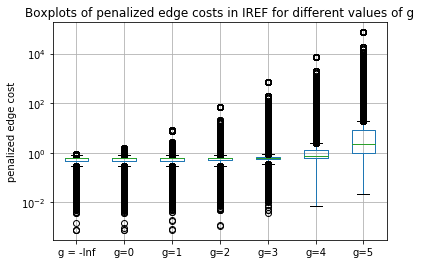

In [12]:
# Boxplot of edge costs under several choices of g
plt.figure()
edge_costs_df.boxplot()
plt.yscale('log')
plt.ylabel('penalized edge cost')
plt.title('Boxplots of penalized edge costs in IREF for different values of g')
plt.show()

## B range

In [13]:
# For a range of g, compute the maximum penalized edge cost
g_range = [0,1,2,3,4,5]
max_penalized_edge_cost = pd.DataFrame(edge_costs_df.max())
max_penalized_edge_cost.columns=['max_penalized_edge_cost']
max_penalized_edge_cost

,max_penalized_edge_cost
g = -Inf,0.859220
g=0,1.588927
g=1,8.156290
g=2,73.829915
g=3,730.566173
g=4,7297.928746
g=5,72971.554482


# Sensitivity analysis for Steiner tree parameters

## Run sensitivity analysis

In [14]:
# Load set of virus interacting genes from Gordon et al.
virus_partners_file_name = "../Data/SARSCov_targets_df.tsv"
virus_interacting_genes = sensitivity.import_virus_partners(virus_partners_file_name)

In [15]:
# Parameters for sensitivity analysis
interactome_file_name = "../Save_RandomizePPI/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
prize_file_name = "../Save_RandomizePPI/terminals_ppi_analysis.tsv"
# Graph hyperparameters
graph_params =  {
                "noise": 0.0, 
                "dummy_mode": "terminals", 
                "exclude_terminals": False, 
                "seed": 1,
                "pruning": 'strong',
                "verbosity_level": 0
                }
# Set sweeping parameters, i.e. configurations (w,b,g)
W_list = np.linspace(start = 0.2, stop = 2, num = 10)
B_list = np.array([5., 10., 15., 20., 25., 30., 35., 40., 45., 50.])

In [55]:
# Run sensitivity analysis
networks_dict = sensitivity.run_sensitivity_analysis(interactome_file_name, 
                                                     prize_file_name, 
                                                     graph_params, 
                                                     W_list, 
                                                     B_list, 
                                                     G=0)

10:34:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:34:58 - OI2: INFO - []
10:34:58 - OI2: INFO - Members of the prize file not present in the interactome:
10:34:58 - OI2: INFO - []


Progress= 0.01


10:34:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:34:59 - OI2: INFO - []
10:34:59 - OI2: INFO - Members of the prize file not present in the interactome:
10:34:59 - OI2: INFO - []


Progress= 0.02


10:34:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:34:59 - OI2: INFO - []
10:34:59 - OI2: INFO - Members of the prize file not present in the interactome:
10:34:59 - OI2: INFO - []


Progress= 0.03


10:35:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:00 - OI2: INFO - []
10:35:00 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:00 - OI2: INFO - []


Progress= 0.04


10:35:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:01 - OI2: INFO - []
10:35:01 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:01 - OI2: INFO - []


Progress= 0.05


10:35:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:02 - OI2: INFO - []
10:35:02 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:02 - OI2: INFO - []


Progress= 0.06


10:35:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:03 - OI2: INFO - []
10:35:03 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:03 - OI2: INFO - []


Progress= 0.07


10:35:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:03 - OI2: INFO - []
10:35:03 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:03 - OI2: INFO - []


Progress= 0.08


10:35:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:04 - OI2: INFO - []
10:35:04 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:04 - OI2: INFO - []


Progress= 0.09


10:35:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:05 - OI2: INFO - []
10:35:05 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:05 - OI2: INFO - []


Progress= 0.1


10:35:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:06 - OI2: INFO - []
10:35:06 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:06 - OI2: INFO - []


Progress= 0.11


10:35:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:07 - OI2: INFO - []
10:35:07 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:07 - OI2: INFO - []


Progress= 0.12


10:35:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:08 - OI2: INFO - []
10:35:08 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:08 - OI2: INFO - []


Progress= 0.13


10:35:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:09 - OI2: INFO - []
10:35:09 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:09 - OI2: INFO - []


Progress= 0.14


10:35:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:10 - OI2: INFO - []
10:35:10 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:10 - OI2: INFO - []


Progress= 0.15


10:35:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:11 - OI2: INFO - []
10:35:11 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:11 - OI2: INFO - []


Progress= 0.16


10:35:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:12 - OI2: INFO - []
10:35:12 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:12 - OI2: INFO - []


Progress= 0.17


10:35:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:13 - OI2: INFO - []
10:35:13 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:13 - OI2: INFO - []


Progress= 0.18


10:35:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:14 - OI2: INFO - []
10:35:14 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:14 - OI2: INFO - []


Progress= 0.19


10:35:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:15 - OI2: INFO - []
10:35:15 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:15 - OI2: INFO - []


Progress= 0.2


10:35:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:16 - OI2: INFO - []
10:35:16 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:16 - OI2: INFO - []


Progress= 0.21


10:35:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:18 - OI2: INFO - []
10:35:18 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:18 - OI2: INFO - []


Progress= 0.22


10:35:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:19 - OI2: INFO - []
10:35:19 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:19 - OI2: INFO - []


Progress= 0.23


10:35:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:20 - OI2: INFO - []
10:35:20 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:20 - OI2: INFO - []


Progress= 0.24


10:35:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:21 - OI2: INFO - []
10:35:21 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:21 - OI2: INFO - []


Progress= 0.25


10:35:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:23 - OI2: INFO - []
10:35:23 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:23 - OI2: INFO - []


Progress= 0.26


10:35:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:24 - OI2: INFO - []
10:35:24 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:24 - OI2: INFO - []


Progress= 0.27


10:35:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:25 - OI2: INFO - []
10:35:25 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:25 - OI2: INFO - []


Progress= 0.28


10:35:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:26 - OI2: INFO - []
10:35:26 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:26 - OI2: INFO - []


Progress= 0.29


10:35:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:27 - OI2: INFO - []
10:35:27 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:27 - OI2: INFO - []


Progress= 0.3


10:35:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:29 - OI2: INFO - []
10:35:29 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:29 - OI2: INFO - []


Progress= 0.31


10:35:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:30 - OI2: INFO - []
10:35:30 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:30 - OI2: INFO - []


Progress= 0.32


10:35:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:31 - OI2: INFO - []
10:35:31 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:31 - OI2: INFO - []


Progress= 0.33


10:35:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:33 - OI2: INFO - []
10:35:33 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:33 - OI2: INFO - []


Progress= 0.34


10:35:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:34 - OI2: INFO - []
10:35:34 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:34 - OI2: INFO - []


Progress= 0.35


10:35:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:35 - OI2: INFO - []
10:35:35 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:35 - OI2: INFO - []


Progress= 0.36


10:35:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:36 - OI2: INFO - []
10:35:36 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:36 - OI2: INFO - []


Progress= 0.37


10:35:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:38 - OI2: INFO - []
10:35:38 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:38 - OI2: INFO - []


Progress= 0.38


10:35:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:39 - OI2: INFO - []
10:35:39 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:39 - OI2: INFO - []


Progress= 0.39


10:35:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:40 - OI2: INFO - []
10:35:40 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:40 - OI2: INFO - []


Progress= 0.4


10:35:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:42 - OI2: INFO - []
10:35:42 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:42 - OI2: INFO - []


Progress= 0.41


10:35:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:43 - OI2: INFO - []
10:35:43 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:43 - OI2: INFO - []


Progress= 0.42


10:35:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:44 - OI2: INFO - []
10:35:44 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:44 - OI2: INFO - []


Progress= 0.43


10:35:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:45 - OI2: INFO - []
10:35:45 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:45 - OI2: INFO - []


Progress= 0.44


10:35:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:47 - OI2: INFO - []
10:35:47 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:47 - OI2: INFO - []


Progress= 0.45


10:35:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:48 - OI2: INFO - []
10:35:48 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:48 - OI2: INFO - []


Progress= 0.46


10:35:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:49 - OI2: INFO - []
10:35:49 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:49 - OI2: INFO - []


Progress= 0.47


10:35:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:51 - OI2: INFO - []
10:35:51 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:51 - OI2: INFO - []


Progress= 0.48


10:35:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:52 - OI2: INFO - []
10:35:52 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:52 - OI2: INFO - []


Progress= 0.49


10:35:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:53 - OI2: INFO - []
10:35:53 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:53 - OI2: INFO - []


Progress= 0.5


10:35:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:54 - OI2: INFO - []
10:35:54 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:54 - OI2: INFO - []


Progress= 0.51


10:35:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:56 - OI2: INFO - []
10:35:56 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:56 - OI2: INFO - []


Progress= 0.52


10:35:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:57 - OI2: INFO - []
10:35:57 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:57 - OI2: INFO - []


Progress= 0.53


10:35:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:35:58 - OI2: INFO - []
10:35:58 - OI2: INFO - Members of the prize file not present in the interactome:
10:35:58 - OI2: INFO - []


Progress= 0.54


10:36:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:00 - OI2: INFO - []
10:36:00 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:00 - OI2: INFO - []


Progress= 0.55


10:36:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:01 - OI2: INFO - []
10:36:01 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:01 - OI2: INFO - []


Progress= 0.56


10:36:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:02 - OI2: INFO - []
10:36:02 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:02 - OI2: INFO - []


Progress= 0.57


10:36:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:04 - OI2: INFO - []
10:36:04 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:04 - OI2: INFO - []


Progress= 0.58


10:36:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:05 - OI2: INFO - []
10:36:05 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:05 - OI2: INFO - []


Progress= 0.59


10:36:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:06 - OI2: INFO - []
10:36:06 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:06 - OI2: INFO - []


Progress= 0.6


10:36:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:07 - OI2: INFO - []
10:36:07 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:07 - OI2: INFO - []


Progress= 0.61


10:36:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:09 - OI2: INFO - []
10:36:09 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:09 - OI2: INFO - []


Progress= 0.62


10:36:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:10 - OI2: INFO - []
10:36:10 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:10 - OI2: INFO - []


Progress= 0.63


10:36:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:11 - OI2: INFO - []
10:36:11 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:12 - OI2: INFO - []


Progress= 0.64


10:36:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:13 - OI2: INFO - []
10:36:13 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:13 - OI2: INFO - []


Progress= 0.65


10:36:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:14 - OI2: INFO - []
10:36:14 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:14 - OI2: INFO - []


Progress= 0.66


10:36:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:15 - OI2: INFO - []
10:36:15 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:15 - OI2: INFO - []


Progress= 0.67


10:36:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:17 - OI2: INFO - []
10:36:17 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:17 - OI2: INFO - []


Progress= 0.68


10:36:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:18 - OI2: INFO - []
10:36:18 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:18 - OI2: INFO - []


Progress= 0.69


10:36:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:19 - OI2: INFO - []
10:36:19 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:19 - OI2: INFO - []


Progress= 0.7


10:36:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:21 - OI2: INFO - []
10:36:21 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:21 - OI2: INFO - []


Progress= 0.71


10:36:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:22 - OI2: INFO - []
10:36:22 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:22 - OI2: INFO - []


Progress= 0.72


10:36:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:23 - OI2: INFO - []
10:36:23 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:23 - OI2: INFO - []


Progress= 0.73


10:36:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:25 - OI2: INFO - []
10:36:25 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:25 - OI2: INFO - []


Progress= 0.74


10:36:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:26 - OI2: INFO - []
10:36:26 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:26 - OI2: INFO - []


Progress= 0.75


10:36:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:27 - OI2: INFO - []
10:36:27 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:27 - OI2: INFO - []


Progress= 0.76


10:36:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:28 - OI2: INFO - []
10:36:28 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:28 - OI2: INFO - []


Progress= 0.77


10:36:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:30 - OI2: INFO - []
10:36:30 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:30 - OI2: INFO - []


Progress= 0.78


10:36:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:31 - OI2: INFO - []
10:36:31 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:31 - OI2: INFO - []


Progress= 0.79


10:36:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:32 - OI2: INFO - []
10:36:32 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:32 - OI2: INFO - []


Progress= 0.8


10:36:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:34 - OI2: INFO - []
10:36:34 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:34 - OI2: INFO - []


Progress= 0.81


10:36:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:35 - OI2: INFO - []
10:36:35 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:35 - OI2: INFO - []


Progress= 0.82


10:36:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:36 - OI2: INFO - []
10:36:36 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:36 - OI2: INFO - []


Progress= 0.83


10:36:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:38 - OI2: INFO - []
10:36:38 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:38 - OI2: INFO - []


Progress= 0.84


10:36:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:39 - OI2: INFO - []
10:36:39 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:39 - OI2: INFO - []


Progress= 0.85


10:36:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:40 - OI2: INFO - []
10:36:40 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:40 - OI2: INFO - []


Progress= 0.86


10:36:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:41 - OI2: INFO - []
10:36:41 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:41 - OI2: INFO - []


Progress= 0.87


10:36:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:43 - OI2: INFO - []
10:36:43 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:43 - OI2: INFO - []


Progress= 0.88


10:36:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:44 - OI2: INFO - []
10:36:44 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:44 - OI2: INFO - []


Progress= 0.89


10:36:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:45 - OI2: INFO - []
10:36:45 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:45 - OI2: INFO - []


Progress= 0.9


10:36:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:47 - OI2: INFO - []
10:36:47 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:47 - OI2: INFO - []


Progress= 0.91


10:36:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:48 - OI2: INFO - []
10:36:48 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:48 - OI2: INFO - []


Progress= 0.92


10:36:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:49 - OI2: INFO - []
10:36:49 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:49 - OI2: INFO - []


Progress= 0.93


10:36:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:50 - OI2: INFO - []
10:36:50 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:50 - OI2: INFO - []


Progress= 0.94


10:36:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:52 - OI2: INFO - []
10:36:52 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:52 - OI2: INFO - []


Progress= 0.95


10:36:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:53 - OI2: INFO - []
10:36:53 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:53 - OI2: INFO - []


Progress= 0.96


10:36:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:54 - OI2: INFO - []
10:36:54 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:54 - OI2: INFO - []


Progress= 0.97


10:36:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:56 - OI2: INFO - []
10:36:56 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:56 - OI2: INFO - []


Progress= 0.98


10:36:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:57 - OI2: INFO - []
10:36:57 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:57 - OI2: INFO - []


Progress= 0.99


10:36:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:36:58 - OI2: INFO - []
10:36:58 - OI2: INFO - Members of the prize file not present in the interactome:
10:36:58 - OI2: INFO - []


Progress= 1.0


In [56]:
# Save as pickle
with open("../Save_RandomizePPI/networks_dict.pkl", "wb") as f: 
    pickle.dump(networks_dict, f)

In [16]:
# Add metatadata
networks_dict = pickle.load(open("../Save_RandomizePPI/networks_dict.pkl", "rb"))
networks_dict = sensitivity.add_metadata(networks_dict, virus_interacting_genes)

In [17]:
# Make summary
networks_summary_df = sensitivity.make_summary(networks_dict, n_terminals, g=0)
networks_summary_df.head()

,index,w,b,g,nodes,edges,number_components,size_components,percentage_terminals,upregulated_terminals,downregulated_terminals,number_transcription_regulators,transcription_regulators,number_of_proteins_interacting_sars,proteins_interacting_sars
w_0.2_b_10.0,1,0.2,10.0,0,198,296,72,"[127, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,6,"[CREB5, ETV6, HOXB3, IRF2, MEOX2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"
w_0.2_b_15.0,2,0.2,15.0,0,198,296,72,"[127, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,6,"[CREB5, ETV6, HOXB3, IRF2, MEOX2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"
w_0.2_b_20.0,3,0.2,20.0,0,198,296,72,"[127, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,6,"[CREB5, ETV6, HOXB3, IRF2, MEOX2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"
w_0.2_b_25.0,4,0.2,25.0,0,198,296,72,"[127, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,6,"[CREB5, ETV6, HOXB3, IRF2, MEOX2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"
w_0.2_b_30.0,5,0.2,30.0,0,198,296,72,"[127, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",1.0,75,87,6,"[CREB5, ETV6, HOXB3, IRF2, MEOX2, TSC22D2]",3,"[EXOSC5, FOXRED2, LOX]"


## Plot node stability heatmaps

<Figure size 432x288 with 0 Axes>

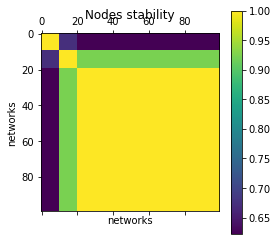

In [18]:
# Stability of selected nodes
mat_allnodes = sensitivity.create_matrix_gene_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_allnodes)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Nodes stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

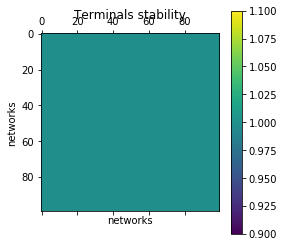

In [19]:
# Stability of selected terminals
mat_terminals = sensitivity.create_matrix_terminal_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_terminals)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Terminals stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

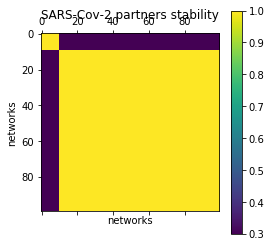

In [20]:
# Stability of selected SARS-Cov-2 partners
mat_sars = sensitivity.create_matrix_sars_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_sars)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('SARS-Cov-2 partners stability')
plt.colorbar()
plt.show()

## Select robust parameters

In [19]:
# Select network corresponding to g=0, w=1.4 and b=40
index_selected = 67
paramstring_selected = networks_summary_df[networks_summary_df['index']==index_selected].index[0]
network_selected = networks_dict[paramstring_selected]

In [20]:
# Save selected network to file
oi.output_networkx_graph_as_interactive_html(network_selected, filename="../Save_RandomizePPI/network_selected.html")
oi.output_networkx_graph_as_pickle(network_selected, filename= '../Save_RandomizePPI/network_selected.pickle')
#oi.output_networkx_graph_as_graphml_for_cytoscape(robust_network, filename= '../Save_RandomizePPI/network_selected.graphml')

PosixPath('/home/louiscam/projects/sars_cov_2/Save_RandomizePPI/network_selected.pickle')

# Sensitivity analysis for virus partners prize

## Run sensitivity analysis

In [64]:
# Identify which SARS-Cov-2 partners are in the terminal list
terminal_partners = set(terminals).intersection(virus_interacting_genes)
print(terminal_partners)

{'EXOSC5', 'FOXRED2', 'LOX'}


In [65]:
# Run sensitivity analysis
interactome_file_name = "../Save_RandomizePPI/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
prize_file_name = "../Save_RandomizePPI/terminals_ppi_analysis.tsv"
# Graph hyperparameters
graph_params =  {
                "noise": 0.0, 
                "dummy_mode": "terminals", 
                "exclude_terminals": False, 
                "seed": 1,
                "pruning": 'strong',
                "verbosity_level": 0,
                "w": 1.4,
                "b": 40,
                "g": 0
                }
# List of values of P
P_list = np.arange(0,0.0016,0.0001)

networks_dict = svp.run_prize_sensitivity_analysis(interactome_file_name, 
                                                   prize_file_name, 
                                                   graph_params, 
                                                   virus_interacting_genes, 
                                                   terminal_partners, 
                                                   P_list)

10:40:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:04 - OI2: INFO - []
10:40:04 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:04 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.0625


10:40:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:06 - OI2: INFO - []
10:40:06 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:06 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.125


10:40:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:08 - OI2: INFO - []
10:40:08 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:08 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.1875


10:40:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:10 - OI2: INFO - []
10:40:10 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:10 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.25


10:40:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:11 - OI2: INFO - []
10:40:11 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:11 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.3125


10:40:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:13 - OI2: INFO - []
10:40:13 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:13 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.375


10:40:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:15 - OI2: INFO - []
10:40:15 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:15 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.4375


10:40:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:17 - OI2: INFO - []
10:40:17 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:17 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.5


10:40:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:19 - OI2: INFO - []
10:40:19 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:19 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.5625


10:40:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:20 - OI2: INFO - []
10:40:20 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:20 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.625


10:40:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:22 - OI2: INFO - []
10:40:22 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:22 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.6875


10:40:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:24 - OI2: INFO - []
10:40:24 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:24 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.75


10:40:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:26 - OI2: INFO - []
10:40:26 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:26 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.8125


10:40:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:28 - OI2: INFO - []
10:40:28 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:28 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.875


10:40:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:30 - OI2: INFO - []
10:40:30 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:30 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 0.9375


10:40:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
10:40:32 - OI2: INFO - []
10:40:32 - OI2: INFO - Members of the prize file not present in the interactome:
10:40:32 - OI2: INFO - ['ATP5MG', 'CEP43', 'COQ8B', 'ELOB', 'ELOC', 'ERO1B', 'HS2ST1', 'HS6ST2', 'MTARC1', 'NARS2', 'NSD2', 'NUP58', 'POGLUT2', 'POGLUT3', 'RETREG3', 'SELENOS', 'SPART', 'TIMM29', 'TLE5', 'TOMM70', 'WASHC4']


Progress= 1.0


In [66]:
# Save as pickle
with open("../Save_RandomizePPI/networks_dict_sarspartners.pkl", "wb") as f: 
    pickle.dump(networks_dict, f)

In [67]:
# Add metadata
networks_dict = pickle.load(open("../Save_RandomizePPI/networks_dict_sarspartners.pkl", "rb"))
networks_dict = svp.add_metadata(networks_dict, virus_interacting_genes)

In [68]:
# Make summary
networks_summary_df = svp.make_summary(networks_dict, n_terminals)
networks_summary_df.head()

,index,p,nodes,edges,number_components,size_components,percentage_terminals,transcription_regulators,number_of_proteins_interacting_sars,proteins_interacting_sars
p_0.0,0,0.0,318,1573,1,[318],1.0,"[CREB3, CREB5, ETV6, HOXB3, IRF2, MEOX2, REL, ...",10,"[ABCC1, CSNK2A2, DDX21, EXOSC5, FOXRED2, LOX, ..."
p_0.0001,1,0.0001,318,1573,1,[318],1.0,"[CREB3, CREB5, ETV6, HOXB3, IRF2, MEOX2, REL, ...",10,"[ABCC1, CSNK2A2, DDX21, EXOSC5, FOXRED2, LOX, ..."
p_0.0002,2,0.0002,318,1568,1,[318],1.0,"[CREB3, CREB5, ETV6, HOXB3, IRF2, MEOX2, REL, ...",11,"[ABCC1, CSNK2A2, DDX21, EXOSC5, FOXRED2, LOX, ..."
p_0.00030000000000000003,3,0.00030000000000000003,321,1574,1,[321],1.0,"[CREB3, CREB5, ETV6, HOXB3, IRF2, MEOX2, REL, ...",13,"[ABCC1, BRD4, CSNK2A2, DDX21, EXOSC5, FOXRED2,..."
p_0.0004,4,0.0004,321,1553,1,[321],1.0,"[CREB3, CREB5, ETV6, HOXB3, IRF2, MEOX2, REL, ...",15,"[ABCC1, BRD4, CSNK2A2, DDX21, EXOSC5, FOXRED2,..."


## Plot number of SARS-Cov-2 partners picked up versus p

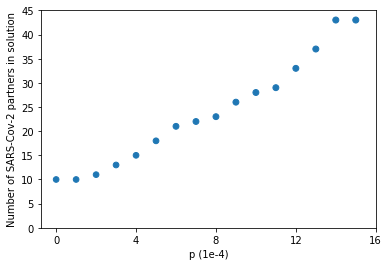

In [70]:
plt.figure()
plt.scatter(x = networks_summary_df['p'], 
            y = networks_summary_df['number_of_proteins_interacting_sars'],
            s = 0.1*networks_summary_df['nodes'])
plt.xlabel('p (1e-4)')
plt.ylabel('Number of SARS-Cov-2 partners in solution')
plt.xticks(np.arange(0,17,4),['0','4','8','12','16'])
plt.yticks(np.arange(0,50,5))
plt.show()

## Plot node stability heatmaps

<Figure size 432x288 with 0 Axes>

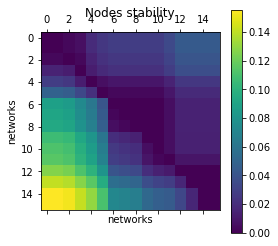

In [71]:
# Stability of selected nodes
mat_allnodes = svp.create_matrix_gene_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_allnodes)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Nodes stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

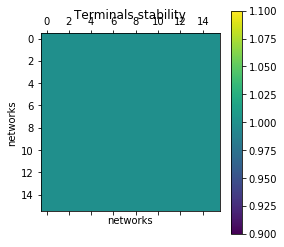

In [72]:
# Stability of selected terminals
mat_terminals = svp.create_matrix_terminal_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_terminals)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('Terminals stability')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

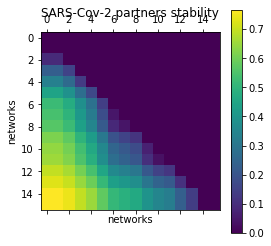

In [73]:
# Stability of selected SARS-Cov-2 partners
mat_sars = svp.create_matrix_sars_overlap_between_networks(networks_summary_df, networks_dict)
plt.figure()
plt.matshow(mat_sars)
plt.xlabel('networks')
plt.ylabel('networks')
plt.title('SARS-Cov-2 partners stability')
plt.colorbar()
plt.show()

## Select robust parameters

In [74]:
# Save network
index_selected = 8
paramstring_selected = networks_summary_df[networks_summary_df['index']==index_selected].index[0]
network_selected2 = networks_dict[paramstring_selected]

In [75]:
# Save selected network to file
oi.output_networkx_graph_as_interactive_html(network_selected2, filename="../Save_RandomizePPI/network_selected_sarspartners.html")
oi.output_networkx_graph_as_pickle(network_selected2, filename= '../Save_RandomizePPI/network_selected_sarspartners.pickle')
#oi.output_networkx_graph_as_graphml_for_cytoscape(network_selected, filename= r'../Save_RandomizePPI/network_selected_sarspartners.graphml')

PosixPath('/home/louiscam/projects/sars_cov_2/Save_RandomizePPI/network_selected_sarspartners.pickle')

# Add drug targets to selected network

## Construct drug/target data

In [21]:
# Compute degree centrality for all nodes in the interactome
graph = oi.Graph(interactome_file_name)
centrality_dic = nx.degree_centrality(graph.interactome_graph)

In [22]:
# Load drug/target data from DrugCentral
drug_target_file_name = '../Data/drug.target.interaction.tsv'
drugcentral_df = drugs2.load_drug_target_data(drug_target_file_name, aff_cst_thresh=5)
# Add degree centrality of gene target and drop drug/target pairs with no affinity constant information
drugcentral_df['degree_centrality'] = [centrality_dic[gene] if (gene in list(centrality_dic.keys())) else None for gene in drugcentral_df['gene']]
drugcentral_df.dropna(axis=0, subset=['affinity_constant'], inplace=True)
drugcentral_df.head()

,gene,drug,protein_target,affinity_constant,affinity_constant_type,degree_centrality
1,CYP2D6,levobupivacaine,Cytochrome P450 2D6,6.706859,IC50,NaN
5,SCN1A,levobupivacaine,Sodium channel protein type 1 subunit alpha,5.790000,IC50,0.000254
9,KCNN4,(s)-nitrendipine,Intermediate conductance calcium-activated pot...,7.600000,IC50,0.000444
10,CACNA1F,(s)-nitrendipine,Voltage-dependent L-type calcium channel subun...,6.000000,IC50,0.000127
13,CACNA1D,(s)-nitrendipine,Voltage-dependent L-type calcium channel subun...,8.400000,IC50,0.000254


In [23]:
# Compute total number of tyrosine kinase inhibitors (tinib suffix)
tinib_drugs = np.unique(drugcentral_df.set_index('drug').filter(like='tinib', axis=0).index)
len(tinib_drugs)

47

In [24]:
# Construct table that gives the number of targets per drug
num_targets_df0 = drugcentral_df.groupby('drug', as_index=False)[['gene']].agg({
    ('num_targets','count'),
    ('num_terminal_targets',lambda gs: len(set(gs).intersection(set(terminals))))
})
max_centrality_df0 = drugcentral_df.groupby('drug', as_index=False)[['degree_centrality']].agg({
    ('max_degree_centrality',max)
})
num_targets_df = pd.DataFrame({'drug': num_targets_df0.index,
                               'num_targets': num_targets_df0['gene']['num_targets'],
                               'num_terminal_targets': num_targets_df0['gene']['num_terminal_targets'],
                               'max_target_centrality': max_centrality_df0['degree_centrality']['max_degree_centrality']}).reset_index(drop=True)
num_targets_df = num_targets_df.sort_values(by='num_targets', ascending=False, inplace=False)
num_targets_df.head(10)

,drug,num_targets,num_terminal_targets,max_target_centrality
1399,sunitinib,260,4,0.047849
1039,nintedanib,218,3,0.033063
951,midostaurin,204,3,0.047849
189,bosutinib,203,1,0.047849
363,crizotinib,148,3,0.047849
1319,ruxolitinib,132,1,0.024242
393,dasatinib,128,2,0.047849
1315,ruboxistaurin,121,1,0.047849
1368,sorafenib,116,4,0.033063
1562,vandetanib,109,3,0.047849


In [25]:
# Load L1000 drugs with correlations
embedded_drugs_file_name = '../Data/final_A549_drug_correlations.csv'
bestdrugs_df = drugs2.load_embedded_drugs(embedded_drugs_file_name, lower_corr_thresh=0.86)
bestdrugs_df.head()

,drug,corr
0,doxapram,0.882798
1,dasatinib,0.882561
2,cyproheptadine,0.882541
3,ribavirin,0.881823
4,ethambutol,0.881799


In [26]:
# Merge L1000 drugs with DrugCentral drug/target dataset
targets_and_drugs_df = drugcentral_df.merge(bestdrugs_df, on = 'drug', how = 'inner')
print(len(np.unique(targets_and_drugs_df['gene'])))
targets_and_drugs_df.head()

610


,gene,drug,protein_target,affinity_constant,affinity_constant_type,degree_centrality,corr
0,CYP19A1,aminoglutethimide,Aromatase,5.110000,IC50,0.000063,0.860848
1,ADRA2A,amitriptyline,Alpha-2A adrenergic receptor,6.879426,Ki,0.000698,0.872172
2,ADRA2C,amitriptyline,Alpha-2C adrenergic receptor,8.065502,Ki,0.000254,0.872172
3,ADRA1D,amitriptyline,Alpha-1D adrenergic receptor,8.251812,Ki,0.001015,0.872172
4,SCN5A,amitriptyline,Sodium channel protein type 5 subunit alpha,5.800000,IC50,0.001777,0.872172


In [27]:
# Compute proportion of drugs in the intersection that are tinibs
tinib_drugs = np.unique(targets_and_drugs_df.set_index('drug').filter(like='tinib', axis=0).index)
prop_tinib = len(tinib_drugs)/len(targets_and_drugs_df)
print(prop_tinib)

0.004092769440654843


## Add drug target information to selected network

In [28]:
network_selected = pickle.load(open('../Save_RandomizePPI/network_selected.pickle', "rb"))
network_selected = drugs2.add_drug_info_to_selected_network(network_selected, targets_and_drugs_df)
# Save enriched network as pickle
oi.output_networkx_graph_as_pickle(network_selected, filename= '../Save_RandomizePPI/network_selected_with_drug_info.pickle')

PosixPath('/home/louiscam/projects/sars_cov_2/Save_RandomizePPI/network_selected_with_drug_info.pickle')

In [29]:
# Construct table of drug targets in the network
drug_targets_df = drugs2.drug_targets_in_selected_network(network_selected)
drug_targets_df.to_csv(r'../Save_RandomizePPI/drug_targets_in_network.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')
drug_targets_df['affinity'] = pd.to_numeric(drug_targets_df['affinity'], errors='coerce')
drug_targets_df.dropna(subset=['affinity'], inplace=True)
drug_targets_df

,name,protein_target,drug,corr,affinity
AR,AR,{Androgen receptor},bicalutamide,0.87447727,7.720
AR,AR,{Androgen receptor},mifepristone,0.8636598,8.330
AURKC,AURKC,{Aurora kinase C},erlotinib,0.8737799,6.220
AURKC,AURKC,{Aurora kinase C},sorafenib,0.86517066,6.680
AURKC,AURKC,{Aurora kinase C},sunitinib,0.8685898,6.660
AURKC,AURKC,{Aurora kinase C},pazopanib,0.86695886,6.120
AURKC,AURKC,{Aurora kinase C},ruxolitinib,0.87487674,5.060
AURKC,AURKC,{Aurora kinase C},axitinib,0.8779775,8.890
BRSK1,BRSK1,{Serine/threonine-protein kinase BRSK1},sunitinib,0.8685898,5.460
CDK17,CDK17,{Cyclin-dependent kinase 17},sorafenib,0.86517066,5.800


In [30]:
# Save drug/target dataframe to csv
drug_targets_df.to_csv(r'../Save_RandomizePPI/final_drug_target_table.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')

# Compare to non-randomized analysis

In [31]:
# Drug/target dataframe in the non-randomized case
drug_targets_df_norandom_file_name = '../Save/final_drug_target_table.tsv'
drug_targets_df_norandom = pd.read_csv(drug_targets_df_norandom_file_name, sep = '\t')
drug_targets_df_norandom.head()

,name,protein_target,drug,corr,affinity
0,ACVR2A,{'Activin receptor type-2A'},dasatinib,0.882561,6.68
1,AURKC,{'Aurora kinase C'},erlotinib,0.873780,6.22
2,AURKC,{'Aurora kinase C'},sorafenib,0.865171,6.68
3,AURKC,{'Aurora kinase C'},sunitinib,0.868590,6.66
4,AURKC,{'Aurora kinase C'},pazopanib,0.866959,6.12


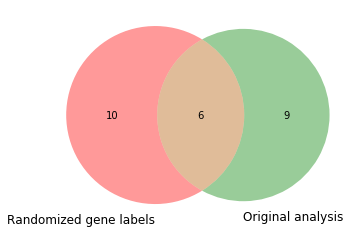

In [32]:
# Common gene targets
targets_random = set(drug_targets_df['name'])
targets_norandom = set(drug_targets_df_norandom['name'])
venn2(subsets = [targets_random,targets_norandom],set_labels = ('Randomized gene labels','Original analysis'))

             drug  num_targets  num_terminal_targets  max_target_centrality
1485  tofacitinib           43                     0               0.018657
1590   vorinostat           32                     0               0.027478
469     docetaxel           13                     0               0.047849
140    belinostat           11                     0               0.027478
652    formoterol            5                     0               0.040678
1213   primaquine            5                     0               0.040678
              drug  num_targets  num_terminal_targets  max_target_centrality
952   mifepristone           10                     0               0.034268
443      digitoxin            9                     0               0.013073
1356   sitagliptin            2                     0               0.001840
170   bicalutamide            2                     0               0.018721
             drug  num_targets  num_terminal_targets  max_target_centrality
1399   

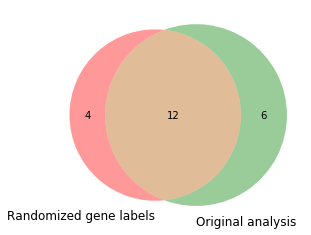

In [33]:
# Common drugs
drugs_random = set(drug_targets_df['drug'])
drugs_norandom = set(drug_targets_df_norandom['drug'])
venn2(subsets = [drugs_random,drugs_norandom],set_labels = ('Randomized gene labels','Original analysis'))
original_minus_random = num_targets_df.loc[num_targets_df['drug'].isin(drugs_norandom.difference(drugs_random))]
random_minus_original = num_targets_df.loc[num_targets_df['drug'].isin(drugs_random.difference(drugs_norandom))]
original_inter_random = num_targets_df.loc[num_targets_df['drug'].isin(drugs_norandom.intersection(drugs_random))]
print(original_minus_random)
print(random_minus_original)
print(original_inter_random)

# Repeat randomization and measure robustness of selected drugs

In [35]:
# Number of repetitions
N = 1000

# Steiner tree parameter
hyperparams = {"w": 1.4, 
               "b": 40, 
               "g": 0,
               "pruning": 'strong',
               "edge_noise": 0, 
               "dummy_mode": "terminals", 
               "seed": 0, 
               "skip_checks": False,
               "verbosity_level": 0}

# Table of selected drugs in the original study
original_drugs = num_targets_df.copy()
original_drugs = original_drugs[num_targets_df['drug'].isin(drugs_norandom)]
original_drugs.insert(3,"num_appearance",np.zeros(len(original_drugs['drug'])))

# Table of drugs that were not selected in the original study
non_original_drugs = num_targets_df.copy()
non_original_drugs = non_original_drugs[~num_targets_df['drug'].isin(drugs_norandom)]
non_original_drugs.insert(3,"num_appearance",np.zeros(len(non_original_drugs['drug'])))

In [36]:
# Set seed
np.random.seed(13)

for i in range(N):

    # Starting edges list
    interactome_file = "../Data/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.txt"
    edges_list = pd.read_csv(interactome_file, sep = '\t')
    
    # Create random PPI
    seed = i
    np.random.seed(seed)
    edges_list['protein1'] = np.random.choice(edges_list['protein1'], size = len(edges_list['protein1']), replace=False)
    #edges_list['protein2'] = np.random.choice(edges_list['protein2'], size = len(edges_list['protein2']), replace=False)
    edges_list.to_csv(r'../Save_RandomizePPI/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.repeat.txt', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')
    interactome_file = "../Save_RandomizePPI/iRefIndex_v14_MIScore_interactome_C9.costs.allcaps.repeat.txt"
    
    # Obtain Steiner Tree
    graph = oi.Graph(interactome_file, hyperparams)
    graph.prepare_prizes(prize_file_name)
    vertex_indices, edge_indices = graph.pcsf()
    _, network_selected = graph.output_forest_as_networkx(vertex_indices, edge_indices)

    # Add following attribute for each gene: is gene druggable, what drug 
    drugs = {gene:list(targets_and_drugs_df.loc[targets_and_drugs_df['gene']==gene]['drug']) for gene in list(network_selected.nodes())}
    drugs_with_corr_aff = {gene:[targets_and_drugs_df['drug'][i]+'%'+str(targets_and_drugs_df['corr'][i])+'%'+str(targets_and_drugs_df['affinity_constant'][i])
                             for i in targets_and_drugs_df.index[targets_and_drugs_df['gene']==gene]]
                             for gene in list(network_selected.nodes())}
    druggable_boolean = {gene:drugs[gene]!=[] for gene in list(network_selected.nodes())}
    protein_target = {gene:list(targets_and_drugs_df.loc[targets_and_drugs_df['gene']==gene]['protein_target']) for gene in list(network_selected.nodes())}
    nx.set_node_attributes(network_selected, druggable_boolean, name='druggable')
    nx.set_node_attributes(network_selected, drugs, name='drug')
    nx.set_node_attributes(network_selected, drugs_with_corr_aff, name='drug_with_corr_aff')
    nx.set_node_attributes(network_selected, protein_target, name='protein_target')

    # Get selected network as dataframe of node
    network_enriched_df = oi.get_networkx_graph_as_dataframe_of_nodes(network_selected)

    # Drug targets in network dataframe
    drug_targets_df = network_enriched_df.copy()
    drug_targets_df = drug_targets_df.loc[drug_targets_df['druggable']==True]
    drug_targets_df['name'] = drug_targets_df.index
    wanted_columns = ['name','drug_with_corr_aff','protein_target']
    drug_targets_df = drug_targets_df[wanted_columns]
    drug_targets_df['protein_target'] = [set(drug_targets_df['protein_target'][i]) for i in np.arange(len(drug_targets_df))]

    # Explode
    drug_targets_df = drugs2.unnesting(drug_targets_df, ['drug_with_corr_aff'])
    drug_targets_df[['drug','corr','affinity']] = drug_targets_df['drug_with_corr_aff'].str.split('%',expand = True)
    wanted_columns2 = ['name','protein_target','drug','corr','affinity']
    drug_targets_df = drug_targets_df[wanted_columns2]

    # Increment number of appearances of original drugs
    final_drug_list = np.unique(drug_targets_df['drug'])
    original_drugs.loc[original_drugs['drug'].isin(set(final_drug_list)),'num_appearance'] += 1
    non_original_drugs.loc[non_original_drugs['drug'].isin(set(final_drug_list)),'num_appearance'] += 1
    print('progress = '+str(i/N*100) + '%')
    
original_drugs.loc[:,'num_appearance'] /= N
non_original_drugs.loc[:,'num_appearance'] /= N

# Save as pickle
with open("../Save_RandomizePPI/original_drugs.pkl", "wb") as f: 
    pickle.dump(original_drugs, f)
with open("../Save_RandomizePPI/non_original_drugs.pkl", "wb") as f: 
    pickle.dump(non_original_drugs, f)

05:08:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:08:31 - OI2: INFO - []
05:08:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:08:31 - OI2: INFO - []


progress = 0.0%


05:08:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:08:35 - OI2: INFO - []
05:08:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:08:35 - OI2: INFO - []


progress = 0.1%


05:08:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:08:39 - OI2: INFO - []
05:08:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:08:39 - OI2: INFO - []


progress = 0.2%


05:08:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:08:44 - OI2: INFO - []
05:08:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:08:44 - OI2: INFO - []


progress = 0.3%


05:08:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:08:51 - OI2: INFO - []
05:08:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:08:51 - OI2: INFO - []


progress = 0.4%


05:08:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:08:56 - OI2: INFO - []
05:08:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:08:56 - OI2: INFO - []


progress = 0.5%


05:08:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:08:59 - OI2: INFO - []
05:08:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:08:59 - OI2: INFO - []


progress = 0.6%


05:09:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:03 - OI2: INFO - []
05:09:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:03 - OI2: INFO - []


progress = 0.7000000000000001%


05:09:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:06 - OI2: INFO - []
05:09:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:06 - OI2: INFO - []


progress = 0.8%


05:09:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:10 - OI2: INFO - []
05:09:10 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:10 - OI2: INFO - []


progress = 0.8999999999999999%


05:09:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:14 - OI2: INFO - []
05:09:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:14 - OI2: INFO - []


progress = 1.0%


05:09:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:18 - OI2: INFO - []
05:09:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:18 - OI2: INFO - []


progress = 1.0999999999999999%


05:09:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:21 - OI2: INFO - []
05:09:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:21 - OI2: INFO - []


progress = 1.2%


05:09:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:24 - OI2: INFO - []
05:09:24 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:24 - OI2: INFO - []


progress = 1.3%


05:09:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:28 - OI2: INFO - []
05:09:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:28 - OI2: INFO - []


progress = 1.4000000000000001%


05:09:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:31 - OI2: INFO - []
05:09:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:31 - OI2: INFO - []


progress = 1.5%


05:09:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:34 - OI2: INFO - []
05:09:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:34 - OI2: INFO - []


progress = 1.6%


05:09:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:38 - OI2: INFO - []
05:09:38 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:38 - OI2: INFO - []


progress = 1.7000000000000002%


05:09:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:41 - OI2: INFO - []
05:09:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:41 - OI2: INFO - []


progress = 1.7999999999999998%


05:09:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:44 - OI2: INFO - []
05:09:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:44 - OI2: INFO - []


progress = 1.9%


05:09:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:47 - OI2: INFO - []
05:09:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:47 - OI2: INFO - []


progress = 2.0%


05:09:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:50 - OI2: INFO - []
05:09:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:50 - OI2: INFO - []


progress = 2.1%


05:09:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:54 - OI2: INFO - []
05:09:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:54 - OI2: INFO - []


progress = 2.1999999999999997%


05:09:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:09:57 - OI2: INFO - []
05:09:57 - OI2: INFO - Members of the prize file not present in the interactome:
05:09:57 - OI2: INFO - []


progress = 2.3%


05:10:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:00 - OI2: INFO - []
05:10:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:00 - OI2: INFO - []


progress = 2.4%


05:10:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:03 - OI2: INFO - []
05:10:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:03 - OI2: INFO - []


progress = 2.5%


05:10:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:06 - OI2: INFO - []
05:10:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:06 - OI2: INFO - []


progress = 2.6%


05:10:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:10 - OI2: INFO - []
05:10:10 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:10 - OI2: INFO - []


progress = 2.7%


05:10:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:14 - OI2: INFO - []
05:10:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:14 - OI2: INFO - []


progress = 2.8000000000000003%


05:10:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:17 - OI2: INFO - []
05:10:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:17 - OI2: INFO - []


progress = 2.9000000000000004%


05:10:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:21 - OI2: INFO - []
05:10:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:21 - OI2: INFO - []


progress = 3.0%


05:10:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:25 - OI2: INFO - []
05:10:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:25 - OI2: INFO - []


progress = 3.1%


05:10:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:29 - OI2: INFO - []
05:10:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:29 - OI2: INFO - []


progress = 3.2%


05:10:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:33 - OI2: INFO - []
05:10:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:33 - OI2: INFO - []


progress = 3.3000000000000003%


05:10:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:36 - OI2: INFO - []
05:10:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:36 - OI2: INFO - []


progress = 3.4000000000000004%


05:10:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:40 - OI2: INFO - []
05:10:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:40 - OI2: INFO - []


progress = 3.5000000000000004%


05:10:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:43 - OI2: INFO - []
05:10:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:44 - OI2: INFO - []


progress = 3.5999999999999996%


05:10:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:47 - OI2: INFO - []
05:10:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:47 - OI2: INFO - []


progress = 3.6999999999999997%


05:10:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:51 - OI2: INFO - []
05:10:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:51 - OI2: INFO - []


progress = 3.8%


05:10:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:54 - OI2: INFO - []
05:10:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:54 - OI2: INFO - []


progress = 3.9%


05:10:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:10:58 - OI2: INFO - []
05:10:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:10:58 - OI2: INFO - []


progress = 4.0%


05:11:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:02 - OI2: INFO - []
05:11:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:02 - OI2: INFO - []


progress = 4.1000000000000005%


05:11:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:06 - OI2: INFO - []
05:11:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:06 - OI2: INFO - []


progress = 4.2%


05:11:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:10 - OI2: INFO - []
05:11:10 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:10 - OI2: INFO - []


progress = 4.3%


05:11:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:13 - OI2: INFO - []
05:11:13 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:13 - OI2: INFO - []


progress = 4.3999999999999995%


05:11:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:17 - OI2: INFO - []
05:11:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:17 - OI2: INFO - []


progress = 4.5%


05:11:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:21 - OI2: INFO - []
05:11:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:21 - OI2: INFO - []


progress = 4.6%


05:11:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:25 - OI2: INFO - []
05:11:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:25 - OI2: INFO - []


progress = 4.7%


05:11:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:28 - OI2: INFO - []
05:11:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:28 - OI2: INFO - []


progress = 4.8%


05:11:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:32 - OI2: INFO - []
05:11:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:32 - OI2: INFO - []


progress = 4.9%


05:11:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:36 - OI2: INFO - []
05:11:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:36 - OI2: INFO - []


progress = 5.0%


05:11:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:39 - OI2: INFO - []
05:11:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:39 - OI2: INFO - []


progress = 5.1%


05:11:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:43 - OI2: INFO - []
05:11:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:43 - OI2: INFO - []


progress = 5.2%


05:11:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:47 - OI2: INFO - []
05:11:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:47 - OI2: INFO - []


progress = 5.3%


05:11:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:50 - OI2: INFO - []
05:11:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:50 - OI2: INFO - []


progress = 5.4%


05:11:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:54 - OI2: INFO - []
05:11:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:54 - OI2: INFO - []


progress = 5.5%


05:11:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:11:58 - OI2: INFO - []
05:11:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:11:58 - OI2: INFO - []


progress = 5.6000000000000005%


05:12:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:01 - OI2: INFO - []
05:12:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:01 - OI2: INFO - []


progress = 5.7%


05:12:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:05 - OI2: INFO - []
05:12:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:05 - OI2: INFO - []


progress = 5.800000000000001%


05:12:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:08 - OI2: INFO - []
05:12:08 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:08 - OI2: INFO - []


progress = 5.8999999999999995%


05:12:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:12 - OI2: INFO - []
05:12:12 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:12 - OI2: INFO - []


progress = 6.0%


05:12:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:16 - OI2: INFO - []
05:12:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:16 - OI2: INFO - []


progress = 6.1%


05:12:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:19 - OI2: INFO - []
05:12:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:19 - OI2: INFO - []


progress = 6.2%


05:12:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:23 - OI2: INFO - []
05:12:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:23 - OI2: INFO - []


progress = 6.3%


05:12:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:27 - OI2: INFO - []
05:12:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:27 - OI2: INFO - []


progress = 6.4%


05:12:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:31 - OI2: INFO - []
05:12:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:31 - OI2: INFO - []


progress = 6.5%


05:12:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:34 - OI2: INFO - []
05:12:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:34 - OI2: INFO - []


progress = 6.6000000000000005%


05:12:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:38 - OI2: INFO - []
05:12:38 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:38 - OI2: INFO - []


progress = 6.7%


05:12:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:42 - OI2: INFO - []
05:12:42 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:42 - OI2: INFO - []


progress = 6.800000000000001%


05:12:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:46 - OI2: INFO - []
05:12:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:46 - OI2: INFO - []


progress = 6.9%


05:12:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:49 - OI2: INFO - []
05:12:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:49 - OI2: INFO - []


progress = 7.000000000000001%


05:12:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:53 - OI2: INFO - []
05:12:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:53 - OI2: INFO - []


progress = 7.1%


05:12:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:12:57 - OI2: INFO - []
05:12:57 - OI2: INFO - Members of the prize file not present in the interactome:
05:12:57 - OI2: INFO - []


progress = 7.199999999999999%


05:13:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:01 - OI2: INFO - []
05:13:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:01 - OI2: INFO - []


progress = 7.3%


05:13:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:05 - OI2: INFO - []
05:13:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:05 - OI2: INFO - []


progress = 7.3999999999999995%


05:13:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:08 - OI2: INFO - []
05:13:08 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:08 - OI2: INFO - []


progress = 7.5%


05:13:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:12 - OI2: INFO - []
05:13:12 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:12 - OI2: INFO - []


progress = 7.6%


05:13:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:16 - OI2: INFO - []
05:13:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:16 - OI2: INFO - []


progress = 7.7%


05:13:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:20 - OI2: INFO - []
05:13:20 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:20 - OI2: INFO - []


progress = 7.8%


05:13:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:23 - OI2: INFO - []
05:13:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:23 - OI2: INFO - []


progress = 7.9%


05:13:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:27 - OI2: INFO - []
05:13:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:27 - OI2: INFO - []


progress = 8.0%


05:13:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:31 - OI2: INFO - []
05:13:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:31 - OI2: INFO - []


progress = 8.1%


05:13:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:34 - OI2: INFO - []
05:13:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:34 - OI2: INFO - []


progress = 8.200000000000001%


05:13:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:38 - OI2: INFO - []
05:13:38 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:38 - OI2: INFO - []


progress = 8.3%


05:13:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:42 - OI2: INFO - []
05:13:42 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:42 - OI2: INFO - []


progress = 8.4%


05:13:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:46 - OI2: INFO - []
05:13:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:46 - OI2: INFO - []


progress = 8.5%


05:13:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:49 - OI2: INFO - []
05:13:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:49 - OI2: INFO - []


progress = 8.6%


05:13:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:53 - OI2: INFO - []
05:13:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:53 - OI2: INFO - []


progress = 8.7%


05:13:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:13:57 - OI2: INFO - []
05:13:57 - OI2: INFO - Members of the prize file not present in the interactome:
05:13:57 - OI2: INFO - []


progress = 8.799999999999999%


05:14:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:01 - OI2: INFO - []
05:14:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:01 - OI2: INFO - []


progress = 8.9%


05:14:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:05 - OI2: INFO - []
05:14:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:05 - OI2: INFO - []


progress = 9.0%


05:14:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:08 - OI2: INFO - []
05:14:08 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:08 - OI2: INFO - []


progress = 9.1%


05:14:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:12 - OI2: INFO - []
05:14:12 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:12 - OI2: INFO - []


progress = 9.2%


05:14:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:16 - OI2: INFO - []
05:14:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:16 - OI2: INFO - []


progress = 9.3%


05:14:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:20 - OI2: INFO - []
05:14:20 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:20 - OI2: INFO - []


progress = 9.4%


05:14:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:24 - OI2: INFO - []
05:14:24 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:24 - OI2: INFO - []


progress = 9.5%


05:14:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:27 - OI2: INFO - []
05:14:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:27 - OI2: INFO - []


progress = 9.6%


05:14:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:31 - OI2: INFO - []
05:14:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:31 - OI2: INFO - []


progress = 9.700000000000001%


05:14:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:35 - OI2: INFO - []
05:14:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:35 - OI2: INFO - []


progress = 9.8%


05:14:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:39 - OI2: INFO - []
05:14:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:39 - OI2: INFO - []


progress = 9.9%


05:14:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:42 - OI2: INFO - []
05:14:42 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:42 - OI2: INFO - []


progress = 10.0%


05:14:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:46 - OI2: INFO - []
05:14:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:46 - OI2: INFO - []


progress = 10.100000000000001%


05:14:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:50 - OI2: INFO - []
05:14:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:50 - OI2: INFO - []


progress = 10.2%


05:14:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:53 - OI2: INFO - []
05:14:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:53 - OI2: INFO - []


progress = 10.299999999999999%


05:14:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:14:57 - OI2: INFO - []
05:14:57 - OI2: INFO - Members of the prize file not present in the interactome:
05:14:57 - OI2: INFO - []


progress = 10.4%


05:15:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:01 - OI2: INFO - []
05:15:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:01 - OI2: INFO - []


progress = 10.5%


05:15:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:05 - OI2: INFO - []
05:15:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:05 - OI2: INFO - []


progress = 10.6%


05:15:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:09 - OI2: INFO - []
05:15:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:09 - OI2: INFO - []


progress = 10.7%


05:15:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:13 - OI2: INFO - []
05:15:13 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:13 - OI2: INFO - []


progress = 10.8%


05:15:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:16 - OI2: INFO - []
05:15:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:16 - OI2: INFO - []


progress = 10.9%


05:15:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:20 - OI2: INFO - []
05:15:20 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:20 - OI2: INFO - []


progress = 11.0%


05:15:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:24 - OI2: INFO - []
05:15:24 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:24 - OI2: INFO - []


progress = 11.1%


05:15:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:28 - OI2: INFO - []
05:15:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:28 - OI2: INFO - []


progress = 11.200000000000001%


05:15:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:31 - OI2: INFO - []
05:15:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:31 - OI2: INFO - []


progress = 11.3%


05:15:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:35 - OI2: INFO - []
05:15:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:35 - OI2: INFO - []


progress = 11.4%


05:15:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:39 - OI2: INFO - []
05:15:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:39 - OI2: INFO - []


progress = 11.5%


05:15:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:43 - OI2: INFO - []
05:15:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:43 - OI2: INFO - []


progress = 11.600000000000001%


05:15:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:46 - OI2: INFO - []
05:15:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:46 - OI2: INFO - []


progress = 11.700000000000001%


05:15:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:50 - OI2: INFO - []
05:15:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:50 - OI2: INFO - []


progress = 11.799999999999999%


05:15:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:54 - OI2: INFO - []
05:15:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:54 - OI2: INFO - []


progress = 11.899999999999999%


05:15:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:15:58 - OI2: INFO - []
05:15:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:15:58 - OI2: INFO - []


progress = 12.0%


05:16:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:02 - OI2: INFO - []
05:16:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:02 - OI2: INFO - []


progress = 12.1%


05:16:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:05 - OI2: INFO - []
05:16:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:05 - OI2: INFO - []


progress = 12.2%


05:16:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:09 - OI2: INFO - []
05:16:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:09 - OI2: INFO - []


progress = 12.3%


05:16:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:13 - OI2: INFO - []
05:16:13 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:13 - OI2: INFO - []


progress = 12.4%


05:16:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:17 - OI2: INFO - []
05:16:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:17 - OI2: INFO - []


progress = 12.5%


05:16:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:21 - OI2: INFO - []
05:16:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:21 - OI2: INFO - []


progress = 12.6%


05:16:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:25 - OI2: INFO - []
05:16:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:25 - OI2: INFO - []


progress = 12.7%


05:16:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:28 - OI2: INFO - []
05:16:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:28 - OI2: INFO - []


progress = 12.8%


05:16:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:32 - OI2: INFO - []
05:16:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:32 - OI2: INFO - []


progress = 12.9%


05:16:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:36 - OI2: INFO - []
05:16:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:36 - OI2: INFO - []


progress = 13.0%


05:16:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:40 - OI2: INFO - []
05:16:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:40 - OI2: INFO - []


progress = 13.100000000000001%


05:16:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:43 - OI2: INFO - []
05:16:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:43 - OI2: INFO - []


progress = 13.200000000000001%


05:16:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:47 - OI2: INFO - []
05:16:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:47 - OI2: INFO - []


progress = 13.3%


05:16:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:51 - OI2: INFO - []
05:16:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:51 - OI2: INFO - []


progress = 13.4%


05:16:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:55 - OI2: INFO - []
05:16:55 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:55 - OI2: INFO - []


progress = 13.5%


05:16:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:16:59 - OI2: INFO - []
05:16:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:16:59 - OI2: INFO - []


progress = 13.600000000000001%


05:17:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:02 - OI2: INFO - []
05:17:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:02 - OI2: INFO - []


progress = 13.700000000000001%


05:17:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:06 - OI2: INFO - []
05:17:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:06 - OI2: INFO - []


progress = 13.8%


05:17:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:10 - OI2: INFO - []
05:17:10 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:10 - OI2: INFO - []


progress = 13.900000000000002%


05:17:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:14 - OI2: INFO - []
05:17:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:14 - OI2: INFO - []


progress = 14.000000000000002%


05:17:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:17 - OI2: INFO - []
05:17:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:17 - OI2: INFO - []


progress = 14.099999999999998%


05:17:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:21 - OI2: INFO - []
05:17:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:21 - OI2: INFO - []


progress = 14.2%


05:17:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:25 - OI2: INFO - []
05:17:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:25 - OI2: INFO - []


progress = 14.299999999999999%


05:17:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:29 - OI2: INFO - []
05:17:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:29 - OI2: INFO - []


progress = 14.399999999999999%


05:17:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:33 - OI2: INFO - []
05:17:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:33 - OI2: INFO - []


progress = 14.499999999999998%


05:17:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:36 - OI2: INFO - []
05:17:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:36 - OI2: INFO - []


progress = 14.6%


05:17:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:40 - OI2: INFO - []
05:17:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:40 - OI2: INFO - []


progress = 14.7%


05:17:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:44 - OI2: INFO - []
05:17:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:44 - OI2: INFO - []


progress = 14.799999999999999%


05:17:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:47 - OI2: INFO - []
05:17:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:47 - OI2: INFO - []


progress = 14.899999999999999%


05:17:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:51 - OI2: INFO - []
05:17:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:51 - OI2: INFO - []


progress = 15.0%


05:17:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:55 - OI2: INFO - []
05:17:55 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:55 - OI2: INFO - []


progress = 15.1%


05:17:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:17:58 - OI2: INFO - []
05:17:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:17:59 - OI2: INFO - []


progress = 15.2%


05:18:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:02 - OI2: INFO - []
05:18:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:02 - OI2: INFO - []


progress = 15.299999999999999%


05:18:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:06 - OI2: INFO - []
05:18:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:06 - OI2: INFO - []


progress = 15.4%


05:18:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:10 - OI2: INFO - []
05:18:10 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:10 - OI2: INFO - []


progress = 15.5%


05:18:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:14 - OI2: INFO - []
05:18:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:14 - OI2: INFO - []


progress = 15.6%


05:18:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:17 - OI2: INFO - []
05:18:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:17 - OI2: INFO - []


progress = 15.7%


05:18:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:22 - OI2: INFO - []
05:18:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:22 - OI2: INFO - []


progress = 15.8%


05:18:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:25 - OI2: INFO - []
05:18:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:25 - OI2: INFO - []


progress = 15.9%


05:18:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:29 - OI2: INFO - []
05:18:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:29 - OI2: INFO - []


progress = 16.0%


05:18:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:33 - OI2: INFO - []
05:18:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:33 - OI2: INFO - []


progress = 16.1%


05:18:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:37 - OI2: INFO - []
05:18:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:37 - OI2: INFO - []


progress = 16.2%


05:18:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:41 - OI2: INFO - []
05:18:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:41 - OI2: INFO - []


progress = 16.3%


05:18:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:44 - OI2: INFO - []
05:18:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:44 - OI2: INFO - []


progress = 16.400000000000002%


05:18:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:48 - OI2: INFO - []
05:18:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:48 - OI2: INFO - []


progress = 16.5%


05:18:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:52 - OI2: INFO - []
05:18:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:52 - OI2: INFO - []


progress = 16.6%


05:18:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:56 - OI2: INFO - []
05:18:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:56 - OI2: INFO - []


progress = 16.7%


05:18:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:18:59 - OI2: INFO - []
05:18:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:18:59 - OI2: INFO - []


progress = 16.8%


05:19:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:03 - OI2: INFO - []
05:19:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:03 - OI2: INFO - []


progress = 16.900000000000002%


05:19:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:07 - OI2: INFO - []
05:19:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:07 - OI2: INFO - []


progress = 17.0%


05:19:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:11 - OI2: INFO - []
05:19:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:11 - OI2: INFO - []


progress = 17.1%


05:19:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:14 - OI2: INFO - []
05:19:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:14 - OI2: INFO - []


progress = 17.2%


05:19:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:18 - OI2: INFO - []
05:19:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:18 - OI2: INFO - []


progress = 17.299999999999997%


05:19:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:22 - OI2: INFO - []
05:19:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:22 - OI2: INFO - []


progress = 17.4%


05:19:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:26 - OI2: INFO - []
05:19:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:26 - OI2: INFO - []


progress = 17.5%


05:19:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:29 - OI2: INFO - []
05:19:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:29 - OI2: INFO - []


progress = 17.599999999999998%


05:19:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:33 - OI2: INFO - []
05:19:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:33 - OI2: INFO - []


progress = 17.7%


05:19:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:37 - OI2: INFO - []
05:19:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:37 - OI2: INFO - []


progress = 17.8%


05:19:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:41 - OI2: INFO - []
05:19:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:41 - OI2: INFO - []


progress = 17.9%


05:19:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:45 - OI2: INFO - []
05:19:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:45 - OI2: INFO - []


progress = 18.0%


05:19:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:48 - OI2: INFO - []
05:19:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:48 - OI2: INFO - []


progress = 18.099999999999998%


05:19:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:52 - OI2: INFO - []
05:19:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:52 - OI2: INFO - []


progress = 18.2%


05:19:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:19:56 - OI2: INFO - []
05:19:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:19:56 - OI2: INFO - []


progress = 18.3%


05:20:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:00 - OI2: INFO - []
05:20:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:00 - OI2: INFO - []


progress = 18.4%


05:20:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:04 - OI2: INFO - []
05:20:04 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:04 - OI2: INFO - []


progress = 18.5%


05:20:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:07 - OI2: INFO - []
05:20:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:07 - OI2: INFO - []


progress = 18.6%


05:20:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:11 - OI2: INFO - []
05:20:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:11 - OI2: INFO - []


progress = 18.7%


05:20:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:15 - OI2: INFO - []
05:20:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:15 - OI2: INFO - []


progress = 18.8%


05:20:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:19 - OI2: INFO - []
05:20:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:19 - OI2: INFO - []


progress = 18.9%


05:20:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:22 - OI2: INFO - []
05:20:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:22 - OI2: INFO - []


progress = 19.0%


05:20:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:26 - OI2: INFO - []
05:20:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:26 - OI2: INFO - []


progress = 19.1%


05:20:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:30 - OI2: INFO - []
05:20:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:30 - OI2: INFO - []


progress = 19.2%


05:20:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:34 - OI2: INFO - []
05:20:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:34 - OI2: INFO - []


progress = 19.3%


05:20:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:37 - OI2: INFO - []
05:20:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:37 - OI2: INFO - []


progress = 19.400000000000002%


05:20:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:41 - OI2: INFO - []
05:20:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:41 - OI2: INFO - []


progress = 19.5%


05:20:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:45 - OI2: INFO - []
05:20:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:45 - OI2: INFO - []


progress = 19.6%


05:20:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:49 - OI2: INFO - []
05:20:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:49 - OI2: INFO - []


progress = 19.7%


05:20:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:52 - OI2: INFO - []
05:20:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:52 - OI2: INFO - []


progress = 19.8%


05:20:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:20:56 - OI2: INFO - []
05:20:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:20:56 - OI2: INFO - []


progress = 19.900000000000002%


05:21:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:00 - OI2: INFO - []
05:21:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:00 - OI2: INFO - []


progress = 20.0%


05:21:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:03 - OI2: INFO - []
05:21:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:03 - OI2: INFO - []


progress = 20.1%


05:21:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:07 - OI2: INFO - []
05:21:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:07 - OI2: INFO - []


progress = 20.200000000000003%


05:21:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:11 - OI2: INFO - []
05:21:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:11 - OI2: INFO - []


progress = 20.3%


05:21:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:15 - OI2: INFO - []
05:21:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:15 - OI2: INFO - []


progress = 20.4%


05:21:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:19 - OI2: INFO - []
05:21:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:19 - OI2: INFO - []


progress = 20.5%


05:21:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:23 - OI2: INFO - []
05:21:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:23 - OI2: INFO - []


progress = 20.599999999999998%


05:21:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:27 - OI2: INFO - []
05:21:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:27 - OI2: INFO - []


progress = 20.7%


05:21:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:30 - OI2: INFO - []
05:21:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:30 - OI2: INFO - []


progress = 20.8%


05:21:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:34 - OI2: INFO - []
05:21:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:34 - OI2: INFO - []


progress = 20.9%


05:21:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:38 - OI2: INFO - []
05:21:38 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:38 - OI2: INFO - []


progress = 21.0%


05:21:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:42 - OI2: INFO - []
05:21:42 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:42 - OI2: INFO - []


progress = 21.099999999999998%


05:21:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:45 - OI2: INFO - []
05:21:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:45 - OI2: INFO - []


progress = 21.2%


05:21:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:49 - OI2: INFO - []
05:21:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:49 - OI2: INFO - []


progress = 21.3%


05:21:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:53 - OI2: INFO - []
05:21:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:53 - OI2: INFO - []


progress = 21.4%


05:21:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:21:56 - OI2: INFO - []
05:21:57 - OI2: INFO - Members of the prize file not present in the interactome:
05:21:57 - OI2: INFO - []


progress = 21.5%


05:22:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:01 - OI2: INFO - []
05:22:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:01 - OI2: INFO - []


progress = 21.6%


05:22:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:04 - OI2: INFO - []
05:22:04 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:04 - OI2: INFO - []


progress = 21.7%


05:22:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:08 - OI2: INFO - []
05:22:08 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:08 - OI2: INFO - []


progress = 21.8%


05:22:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:12 - OI2: INFO - []
05:22:12 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:12 - OI2: INFO - []


progress = 21.9%


05:22:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:16 - OI2: INFO - []
05:22:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:16 - OI2: INFO - []


progress = 22.0%


05:22:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:20 - OI2: INFO - []
05:22:20 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:20 - OI2: INFO - []


progress = 22.1%


05:22:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:23 - OI2: INFO - []
05:22:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:23 - OI2: INFO - []


progress = 22.2%


05:22:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:27 - OI2: INFO - []
05:22:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:27 - OI2: INFO - []


progress = 22.3%


05:22:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:31 - OI2: INFO - []
05:22:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:31 - OI2: INFO - []


progress = 22.400000000000002%


05:22:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:35 - OI2: INFO - []
05:22:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:35 - OI2: INFO - []


progress = 22.5%


05:22:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:39 - OI2: INFO - []
05:22:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:39 - OI2: INFO - []


progress = 22.6%


05:22:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:42 - OI2: INFO - []
05:22:42 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:42 - OI2: INFO - []


progress = 22.7%


05:22:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:46 - OI2: INFO - []
05:22:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:46 - OI2: INFO - []


progress = 22.8%


05:22:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:50 - OI2: INFO - []
05:22:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:50 - OI2: INFO - []


progress = 22.900000000000002%


05:22:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:54 - OI2: INFO - []
05:22:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:54 - OI2: INFO - []


progress = 23.0%


05:22:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:22:57 - OI2: INFO - []
05:22:57 - OI2: INFO - Members of the prize file not present in the interactome:
05:22:57 - OI2: INFO - []


progress = 23.1%


05:23:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:01 - OI2: INFO - []
05:23:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:01 - OI2: INFO - []


progress = 23.200000000000003%


05:23:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:05 - OI2: INFO - []
05:23:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:05 - OI2: INFO - []


progress = 23.3%


05:23:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:09 - OI2: INFO - []
05:23:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:09 - OI2: INFO - []


progress = 23.400000000000002%


05:23:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:13 - OI2: INFO - []
05:23:13 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:13 - OI2: INFO - []


progress = 23.5%


05:23:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:16 - OI2: INFO - []
05:23:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:16 - OI2: INFO - []


progress = 23.599999999999998%


05:23:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:20 - OI2: INFO - []
05:23:20 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:20 - OI2: INFO - []


progress = 23.7%


05:23:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:24 - OI2: INFO - []
05:23:24 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:24 - OI2: INFO - []


progress = 23.799999999999997%


05:23:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:27 - OI2: INFO - []
05:23:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:27 - OI2: INFO - []


progress = 23.9%


05:23:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:31 - OI2: INFO - []
05:23:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:31 - OI2: INFO - []


progress = 24.0%


05:23:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:35 - OI2: INFO - []
05:23:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:35 - OI2: INFO - []


progress = 24.099999999999998%


05:23:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:39 - OI2: INFO - []
05:23:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:39 - OI2: INFO - []


progress = 24.2%


05:23:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:42 - OI2: INFO - []
05:23:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:43 - OI2: INFO - []


progress = 24.3%


05:23:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:47 - OI2: INFO - []
05:23:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:47 - OI2: INFO - []


progress = 24.4%


05:23:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:50 - OI2: INFO - []
05:23:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:50 - OI2: INFO - []


progress = 24.5%


05:23:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:54 - OI2: INFO - []
05:23:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:54 - OI2: INFO - []


progress = 24.6%


05:23:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:23:58 - OI2: INFO - []
05:23:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:23:58 - OI2: INFO - []


progress = 24.7%


05:24:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:02 - OI2: INFO - []
05:24:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:02 - OI2: INFO - []


progress = 24.8%


05:24:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:05 - OI2: INFO - []
05:24:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:05 - OI2: INFO - []


progress = 24.9%


05:24:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:09 - OI2: INFO - []
05:24:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:09 - OI2: INFO - []


progress = 25.0%


05:24:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:13 - OI2: INFO - []
05:24:13 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:13 - OI2: INFO - []


progress = 25.1%


05:24:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:17 - OI2: INFO - []
05:24:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:17 - OI2: INFO - []


progress = 25.2%


05:24:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:21 - OI2: INFO - []
05:24:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:21 - OI2: INFO - []


progress = 25.3%


05:24:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:24 - OI2: INFO - []
05:24:24 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:24 - OI2: INFO - []


progress = 25.4%


05:24:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:28 - OI2: INFO - []
05:24:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:28 - OI2: INFO - []


progress = 25.5%


05:24:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:32 - OI2: INFO - []
05:24:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:32 - OI2: INFO - []


progress = 25.6%


05:24:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:36 - OI2: INFO - []
05:24:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:36 - OI2: INFO - []


progress = 25.7%


05:24:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:40 - OI2: INFO - []
05:24:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:40 - OI2: INFO - []


progress = 25.8%


05:24:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:43 - OI2: INFO - []
05:24:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:43 - OI2: INFO - []


progress = 25.900000000000002%


05:24:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:47 - OI2: INFO - []
05:24:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:47 - OI2: INFO - []


progress = 26.0%


05:24:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:51 - OI2: INFO - []
05:24:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:51 - OI2: INFO - []


progress = 26.1%


05:24:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:54 - OI2: INFO - []
05:24:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:54 - OI2: INFO - []


progress = 26.200000000000003%


05:24:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:24:58 - OI2: INFO - []
05:24:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:24:58 - OI2: INFO - []


progress = 26.3%


05:25:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:02 - OI2: INFO - []
05:25:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:02 - OI2: INFO - []


progress = 26.400000000000002%


05:25:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:06 - OI2: INFO - []
05:25:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:06 - OI2: INFO - []


progress = 26.5%


05:25:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:09 - OI2: INFO - []
05:25:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:09 - OI2: INFO - []


progress = 26.6%


05:25:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:13 - OI2: INFO - []
05:25:13 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:13 - OI2: INFO - []


progress = 26.700000000000003%


05:25:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:17 - OI2: INFO - []
05:25:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:17 - OI2: INFO - []


progress = 26.8%


05:25:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:21 - OI2: INFO - []
05:25:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:21 - OI2: INFO - []


progress = 26.900000000000002%


05:25:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:24 - OI2: INFO - []
05:25:24 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:24 - OI2: INFO - []


progress = 27.0%


05:25:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:28 - OI2: INFO - []
05:25:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:28 - OI2: INFO - []


progress = 27.1%


05:25:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:32 - OI2: INFO - []
05:25:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:32 - OI2: INFO - []


progress = 27.200000000000003%


05:25:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:35 - OI2: INFO - []
05:25:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:35 - OI2: INFO - []


progress = 27.3%


05:25:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:39 - OI2: INFO - []
05:25:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:39 - OI2: INFO - []


progress = 27.400000000000002%


05:25:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:43 - OI2: INFO - []
05:25:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:43 - OI2: INFO - []


progress = 27.500000000000004%


05:25:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:46 - OI2: INFO - []
05:25:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:46 - OI2: INFO - []


progress = 27.6%


05:25:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:50 - OI2: INFO - []
05:25:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:50 - OI2: INFO - []


progress = 27.700000000000003%


05:25:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:54 - OI2: INFO - []
05:25:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:54 - OI2: INFO - []


progress = 27.800000000000004%


05:25:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:25:58 - OI2: INFO - []
05:25:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:25:58 - OI2: INFO - []


progress = 27.900000000000002%


05:26:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:01 - OI2: INFO - []
05:26:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:01 - OI2: INFO - []


progress = 28.000000000000004%


05:26:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:05 - OI2: INFO - []
05:26:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:05 - OI2: INFO - []


progress = 28.1%


05:26:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:09 - OI2: INFO - []
05:26:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:09 - OI2: INFO - []


progress = 28.199999999999996%


05:26:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:13 - OI2: INFO - []
05:26:13 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:13 - OI2: INFO - []


progress = 28.299999999999997%


05:26:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:17 - OI2: INFO - []
05:26:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:17 - OI2: INFO - []


progress = 28.4%


05:26:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:20 - OI2: INFO - []
05:26:20 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:20 - OI2: INFO - []


progress = 28.499999999999996%


05:26:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:24 - OI2: INFO - []
05:26:24 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:24 - OI2: INFO - []


progress = 28.599999999999998%


05:26:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:28 - OI2: INFO - []
05:26:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:28 - OI2: INFO - []


progress = 28.7%


05:26:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:32 - OI2: INFO - []
05:26:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:32 - OI2: INFO - []


progress = 28.799999999999997%


05:26:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:36 - OI2: INFO - []
05:26:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:36 - OI2: INFO - []


progress = 28.9%


05:26:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:39 - OI2: INFO - []
05:26:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:40 - OI2: INFO - []


progress = 28.999999999999996%


05:26:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:43 - OI2: INFO - []
05:26:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:43 - OI2: INFO - []


progress = 29.099999999999998%


05:26:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:47 - OI2: INFO - []
05:26:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:47 - OI2: INFO - []


progress = 29.2%


05:26:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:51 - OI2: INFO - []
05:26:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:51 - OI2: INFO - []


progress = 29.299999999999997%


05:26:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:55 - OI2: INFO - []
05:26:55 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:55 - OI2: INFO - []


progress = 29.4%


05:26:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:26:58 - OI2: INFO - []
05:26:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:26:58 - OI2: INFO - []


progress = 29.5%


05:27:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:02 - OI2: INFO - []
05:27:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:02 - OI2: INFO - []


progress = 29.599999999999998%


05:27:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:06 - OI2: INFO - []
05:27:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:06 - OI2: INFO - []


progress = 29.7%


05:27:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:10 - OI2: INFO - []
05:27:10 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:10 - OI2: INFO - []


progress = 29.799999999999997%


05:27:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:14 - OI2: INFO - []
05:27:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:14 - OI2: INFO - []


progress = 29.9%


05:27:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:18 - OI2: INFO - []
05:27:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:18 - OI2: INFO - []


progress = 30.0%


05:27:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:21 - OI2: INFO - []
05:27:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:21 - OI2: INFO - []


progress = 30.099999999999998%


05:27:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:25 - OI2: INFO - []
05:27:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:25 - OI2: INFO - []


progress = 30.2%


05:27:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:29 - OI2: INFO - []
05:27:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:29 - OI2: INFO - []


progress = 30.3%


05:27:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:33 - OI2: INFO - []
05:27:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:33 - OI2: INFO - []


progress = 30.4%


05:27:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:37 - OI2: INFO - []
05:27:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:37 - OI2: INFO - []


progress = 30.5%


05:27:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:40 - OI2: INFO - []
05:27:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:40 - OI2: INFO - []


progress = 30.599999999999998%


05:27:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:44 - OI2: INFO - []
05:27:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:44 - OI2: INFO - []


progress = 30.7%


05:27:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:48 - OI2: INFO - []
05:27:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:48 - OI2: INFO - []


progress = 30.8%


05:27:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:52 - OI2: INFO - []
05:27:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:52 - OI2: INFO - []


progress = 30.9%


05:27:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:55 - OI2: INFO - []
05:27:55 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:55 - OI2: INFO - []


progress = 31.0%


05:27:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:27:59 - OI2: INFO - []
05:27:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:27:59 - OI2: INFO - []


progress = 31.1%


05:28:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:03 - OI2: INFO - []
05:28:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:03 - OI2: INFO - []


progress = 31.2%


05:28:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:07 - OI2: INFO - []
05:28:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:07 - OI2: INFO - []


progress = 31.3%


05:28:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:11 - OI2: INFO - []
05:28:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:11 - OI2: INFO - []


progress = 31.4%


05:28:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:14 - OI2: INFO - []
05:28:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:14 - OI2: INFO - []


progress = 31.5%


05:28:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:18 - OI2: INFO - []
05:28:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:18 - OI2: INFO - []


progress = 31.6%


05:28:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:22 - OI2: INFO - []
05:28:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:22 - OI2: INFO - []


progress = 31.7%


05:28:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:26 - OI2: INFO - []
05:28:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:26 - OI2: INFO - []


progress = 31.8%


05:28:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:30 - OI2: INFO - []
05:28:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:30 - OI2: INFO - []


progress = 31.900000000000002%


05:28:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:33 - OI2: INFO - []
05:28:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:33 - OI2: INFO - []


progress = 32.0%


05:28:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:37 - OI2: INFO - []
05:28:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:37 - OI2: INFO - []


progress = 32.1%


05:28:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:41 - OI2: INFO - []
05:28:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:41 - OI2: INFO - []


progress = 32.2%


05:28:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:44 - OI2: INFO - []
05:28:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:44 - OI2: INFO - []


progress = 32.300000000000004%


05:28:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:48 - OI2: INFO - []
05:28:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:48 - OI2: INFO - []


progress = 32.4%


05:28:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:52 - OI2: INFO - []
05:28:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:52 - OI2: INFO - []


progress = 32.5%


05:28:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:56 - OI2: INFO - []
05:28:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:56 - OI2: INFO - []


progress = 32.6%


05:28:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:28:59 - OI2: INFO - []
05:28:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:28:59 - OI2: INFO - []


progress = 32.7%


05:29:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:03 - OI2: INFO - []
05:29:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:03 - OI2: INFO - []


progress = 32.800000000000004%


05:29:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:07 - OI2: INFO - []
05:29:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:07 - OI2: INFO - []


progress = 32.9%


05:29:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:11 - OI2: INFO - []
05:29:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:11 - OI2: INFO - []


progress = 33.0%


05:29:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:14 - OI2: INFO - []
05:29:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:14 - OI2: INFO - []


progress = 33.1%


05:29:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:18 - OI2: INFO - []
05:29:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:18 - OI2: INFO - []


progress = 33.2%


05:29:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:22 - OI2: INFO - []
05:29:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:22 - OI2: INFO - []


progress = 33.300000000000004%


05:29:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:26 - OI2: INFO - []
05:29:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:26 - OI2: INFO - []


progress = 33.4%


05:29:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:29 - OI2: INFO - []
05:29:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:29 - OI2: INFO - []


progress = 33.5%


05:29:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:33 - OI2: INFO - []
05:29:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:33 - OI2: INFO - []


progress = 33.6%


05:29:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:37 - OI2: INFO - []
05:29:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:37 - OI2: INFO - []


progress = 33.7%


05:29:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:41 - OI2: INFO - []
05:29:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:41 - OI2: INFO - []


progress = 33.800000000000004%


05:29:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:45 - OI2: INFO - []
05:29:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:45 - OI2: INFO - []


progress = 33.900000000000006%


05:29:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:48 - OI2: INFO - []
05:29:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:48 - OI2: INFO - []


progress = 34.0%


05:29:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:52 - OI2: INFO - []
05:29:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:52 - OI2: INFO - []


progress = 34.1%


05:29:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:56 - OI2: INFO - []
05:29:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:56 - OI2: INFO - []


progress = 34.2%


05:29:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:29:59 - OI2: INFO - []
05:29:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:29:59 - OI2: INFO - []


progress = 34.300000000000004%


05:30:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:03 - OI2: INFO - []
05:30:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:03 - OI2: INFO - []


progress = 34.4%


05:30:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:07 - OI2: INFO - []
05:30:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:07 - OI2: INFO - []


progress = 34.5%


05:30:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:11 - OI2: INFO - []
05:30:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:11 - OI2: INFO - []


progress = 34.599999999999994%


05:30:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:15 - OI2: INFO - []
05:30:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:15 - OI2: INFO - []


progress = 34.699999999999996%


05:30:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:18 - OI2: INFO - []
05:30:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:18 - OI2: INFO - []


progress = 34.8%


05:30:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:22 - OI2: INFO - []
05:30:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:22 - OI2: INFO - []


progress = 34.9%


05:30:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:25 - OI2: INFO - []
05:30:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:26 - OI2: INFO - []


progress = 35.0%


05:30:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:29 - OI2: INFO - []
05:30:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:29 - OI2: INFO - []


progress = 35.099999999999994%


05:30:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:33 - OI2: INFO - []
05:30:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:33 - OI2: INFO - []


progress = 35.199999999999996%


05:30:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:37 - OI2: INFO - []
05:30:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:37 - OI2: INFO - []


progress = 35.3%


05:30:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:40 - OI2: INFO - []
05:30:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:40 - OI2: INFO - []


progress = 35.4%


05:30:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:45 - OI2: INFO - []
05:30:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:45 - OI2: INFO - []


progress = 35.5%


05:30:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:48 - OI2: INFO - []
05:30:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:48 - OI2: INFO - []


progress = 35.6%


05:30:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:52 - OI2: INFO - []
05:30:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:52 - OI2: INFO - []


progress = 35.699999999999996%


05:30:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:30:56 - OI2: INFO - []
05:30:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:30:56 - OI2: INFO - []


progress = 35.8%


05:31:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:00 - OI2: INFO - []
05:31:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:00 - OI2: INFO - []


progress = 35.9%


05:31:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:03 - OI2: INFO - []
05:31:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:03 - OI2: INFO - []


progress = 36.0%


05:31:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:07 - OI2: INFO - []
05:31:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:07 - OI2: INFO - []


progress = 36.1%


05:31:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:11 - OI2: INFO - []
05:31:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:11 - OI2: INFO - []


progress = 36.199999999999996%


05:31:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:14 - OI2: INFO - []
05:31:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:14 - OI2: INFO - []


progress = 36.3%


05:31:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:18 - OI2: INFO - []
05:31:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:18 - OI2: INFO - []


progress = 36.4%


05:31:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:22 - OI2: INFO - []
05:31:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:22 - OI2: INFO - []


progress = 36.5%


05:31:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:26 - OI2: INFO - []
05:31:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:26 - OI2: INFO - []


progress = 36.6%


05:31:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:29 - OI2: INFO - []
05:31:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:29 - OI2: INFO - []


progress = 36.7%


05:31:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:33 - OI2: INFO - []
05:31:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:33 - OI2: INFO - []


progress = 36.8%


05:31:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:37 - OI2: INFO - []
05:31:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:37 - OI2: INFO - []


progress = 36.9%


05:31:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:41 - OI2: INFO - []
05:31:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:41 - OI2: INFO - []


progress = 37.0%


05:31:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:45 - OI2: INFO - []
05:31:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:45 - OI2: INFO - []


progress = 37.1%


05:31:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:48 - OI2: INFO - []
05:31:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:48 - OI2: INFO - []


progress = 37.2%


05:31:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:52 - OI2: INFO - []
05:31:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:52 - OI2: INFO - []


progress = 37.3%


05:31:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:31:56 - OI2: INFO - []
05:31:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:31:56 - OI2: INFO - []


progress = 37.4%


05:32:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:00 - OI2: INFO - []
05:32:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:00 - OI2: INFO - []


progress = 37.5%


05:32:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:04 - OI2: INFO - []
05:32:04 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:04 - OI2: INFO - []


progress = 37.6%


05:32:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:07 - OI2: INFO - []
05:32:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:07 - OI2: INFO - []


progress = 37.7%


05:32:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:11 - OI2: INFO - []
05:32:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:11 - OI2: INFO - []


progress = 37.8%


05:32:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:15 - OI2: INFO - []
05:32:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:15 - OI2: INFO - []


progress = 37.9%


05:32:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:19 - OI2: INFO - []
05:32:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:19 - OI2: INFO - []


progress = 38.0%


05:32:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:22 - OI2: INFO - []
05:32:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:22 - OI2: INFO - []


progress = 38.1%


05:32:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:26 - OI2: INFO - []
05:32:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:26 - OI2: INFO - []


progress = 38.2%


05:32:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:30 - OI2: INFO - []
05:32:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:30 - OI2: INFO - []


progress = 38.3%


05:32:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:34 - OI2: INFO - []
05:32:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:34 - OI2: INFO - []


progress = 38.4%


05:32:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:37 - OI2: INFO - []
05:32:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:37 - OI2: INFO - []


progress = 38.5%


05:32:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:41 - OI2: INFO - []
05:32:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:41 - OI2: INFO - []


progress = 38.6%


05:32:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:45 - OI2: INFO - []
05:32:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:45 - OI2: INFO - []


progress = 38.7%


05:32:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:49 - OI2: INFO - []
05:32:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:49 - OI2: INFO - []


progress = 38.800000000000004%


05:32:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:52 - OI2: INFO - []
05:32:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:52 - OI2: INFO - []


progress = 38.9%


05:32:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:32:56 - OI2: INFO - []
05:32:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:32:56 - OI2: INFO - []


progress = 39.0%


05:33:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:00 - OI2: INFO - []
05:33:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:00 - OI2: INFO - []


progress = 39.1%


05:33:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:03 - OI2: INFO - []
05:33:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:03 - OI2: INFO - []


progress = 39.2%


05:33:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:07 - OI2: INFO - []
05:33:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:07 - OI2: INFO - []


progress = 39.300000000000004%


05:33:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:11 - OI2: INFO - []
05:33:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:11 - OI2: INFO - []


progress = 39.4%


05:33:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:15 - OI2: INFO - []
05:33:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:15 - OI2: INFO - []


progress = 39.5%


05:33:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:19 - OI2: INFO - []
05:33:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:19 - OI2: INFO - []


progress = 39.6%


05:33:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:22 - OI2: INFO - []
05:33:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:22 - OI2: INFO - []


progress = 39.7%


05:33:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:26 - OI2: INFO - []
05:33:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:26 - OI2: INFO - []


progress = 39.800000000000004%


05:33:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:30 - OI2: INFO - []
05:33:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:30 - OI2: INFO - []


progress = 39.900000000000006%


05:33:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:34 - OI2: INFO - []
05:33:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:34 - OI2: INFO - []


progress = 40.0%


05:33:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:38 - OI2: INFO - []
05:33:38 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:38 - OI2: INFO - []


progress = 40.1%


05:33:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:41 - OI2: INFO - []
05:33:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:41 - OI2: INFO - []


progress = 40.2%


05:33:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:45 - OI2: INFO - []
05:33:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:45 - OI2: INFO - []


progress = 40.300000000000004%


05:33:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:49 - OI2: INFO - []
05:33:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:49 - OI2: INFO - []


progress = 40.400000000000006%


05:33:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:53 - OI2: INFO - []
05:33:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:53 - OI2: INFO - []


progress = 40.5%


05:33:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:33:56 - OI2: INFO - []
05:33:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:33:56 - OI2: INFO - []


progress = 40.6%


05:34:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:00 - OI2: INFO - []
05:34:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:00 - OI2: INFO - []


progress = 40.699999999999996%


05:34:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:04 - OI2: INFO - []
05:34:04 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:04 - OI2: INFO - []


progress = 40.8%


05:34:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:08 - OI2: INFO - []
05:34:08 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:08 - OI2: INFO - []


progress = 40.9%


05:34:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:11 - OI2: INFO - []
05:34:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:11 - OI2: INFO - []


progress = 41.0%


05:34:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:15 - OI2: INFO - []
05:34:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:15 - OI2: INFO - []


progress = 41.099999999999994%


05:34:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:19 - OI2: INFO - []
05:34:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:19 - OI2: INFO - []


progress = 41.199999999999996%


05:34:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:23 - OI2: INFO - []
05:34:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:23 - OI2: INFO - []


progress = 41.3%


05:34:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:26 - OI2: INFO - []
05:34:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:26 - OI2: INFO - []


progress = 41.4%


05:34:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:30 - OI2: INFO - []
05:34:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:30 - OI2: INFO - []


progress = 41.5%


05:34:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:34 - OI2: INFO - []
05:34:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:34 - OI2: INFO - []


progress = 41.6%


05:34:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:38 - OI2: INFO - []
05:34:38 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:38 - OI2: INFO - []


progress = 41.699999999999996%


05:34:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:42 - OI2: INFO - []
05:34:42 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:42 - OI2: INFO - []


progress = 41.8%


05:34:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:45 - OI2: INFO - []
05:34:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:45 - OI2: INFO - []


progress = 41.9%


05:34:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:49 - OI2: INFO - []
05:34:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:49 - OI2: INFO - []


progress = 42.0%


05:34:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:53 - OI2: INFO - []
05:34:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:53 - OI2: INFO - []


progress = 42.1%


05:34:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:34:57 - OI2: INFO - []
05:34:57 - OI2: INFO - Members of the prize file not present in the interactome:
05:34:57 - OI2: INFO - []


progress = 42.199999999999996%


05:35:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:01 - OI2: INFO - []
05:35:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:01 - OI2: INFO - []


progress = 42.3%


05:35:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:05 - OI2: INFO - []
05:35:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:05 - OI2: INFO - []


progress = 42.4%


05:35:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:08 - OI2: INFO - []
05:35:08 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:08 - OI2: INFO - []


progress = 42.5%


05:35:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:12 - OI2: INFO - []
05:35:12 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:12 - OI2: INFO - []


progress = 42.6%


05:35:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:16 - OI2: INFO - []
05:35:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:16 - OI2: INFO - []


progress = 42.699999999999996%


05:35:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:20 - OI2: INFO - []
05:35:20 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:20 - OI2: INFO - []


progress = 42.8%


05:35:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:23 - OI2: INFO - []
05:35:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:23 - OI2: INFO - []


progress = 42.9%


05:35:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:27 - OI2: INFO - []
05:35:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:27 - OI2: INFO - []


progress = 43.0%


05:35:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:31 - OI2: INFO - []
05:35:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:31 - OI2: INFO - []


progress = 43.1%


05:35:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:35 - OI2: INFO - []
05:35:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:35 - OI2: INFO - []


progress = 43.2%


05:35:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:39 - OI2: INFO - []
05:35:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:39 - OI2: INFO - []


progress = 43.3%


05:35:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:42 - OI2: INFO - []
05:35:42 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:42 - OI2: INFO - []


progress = 43.4%


05:35:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:46 - OI2: INFO - []
05:35:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:46 - OI2: INFO - []


progress = 43.5%


05:35:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:50 - OI2: INFO - []
05:35:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:50 - OI2: INFO - []


progress = 43.6%


05:35:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:54 - OI2: INFO - []
05:35:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:54 - OI2: INFO - []


progress = 43.7%


05:35:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:35:58 - OI2: INFO - []
05:35:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:35:58 - OI2: INFO - []


progress = 43.8%


05:36:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:02 - OI2: INFO - []
05:36:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:02 - OI2: INFO - []


progress = 43.9%


05:36:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:05 - OI2: INFO - []
05:36:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:05 - OI2: INFO - []


progress = 44.0%


05:36:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:09 - OI2: INFO - []
05:36:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:09 - OI2: INFO - []


progress = 44.1%


05:36:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:13 - OI2: INFO - []
05:36:13 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:13 - OI2: INFO - []


progress = 44.2%


05:36:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:17 - OI2: INFO - []
05:36:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:17 - OI2: INFO - []


progress = 44.3%


05:36:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:21 - OI2: INFO - []
05:36:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:21 - OI2: INFO - []


progress = 44.4%


05:36:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:24 - OI2: INFO - []
05:36:24 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:24 - OI2: INFO - []


progress = 44.5%


05:36:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:28 - OI2: INFO - []
05:36:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:28 - OI2: INFO - []


progress = 44.6%


05:36:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:32 - OI2: INFO - []
05:36:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:32 - OI2: INFO - []


progress = 44.7%


05:36:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:36 - OI2: INFO - []
05:36:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:36 - OI2: INFO - []


progress = 44.800000000000004%


05:36:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:39 - OI2: INFO - []
05:36:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:39 - OI2: INFO - []


progress = 44.9%


05:36:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:43 - OI2: INFO - []
05:36:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:43 - OI2: INFO - []


progress = 45.0%


05:36:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:47 - OI2: INFO - []
05:36:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:47 - OI2: INFO - []


progress = 45.1%


05:36:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:51 - OI2: INFO - []
05:36:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:51 - OI2: INFO - []


progress = 45.2%


05:36:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:55 - OI2: INFO - []
05:36:55 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:55 - OI2: INFO - []


progress = 45.300000000000004%


05:36:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:36:58 - OI2: INFO - []
05:36:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:36:58 - OI2: INFO - []


progress = 45.4%


05:37:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:02 - OI2: INFO - []
05:37:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:02 - OI2: INFO - []


progress = 45.5%


05:37:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:06 - OI2: INFO - []
05:37:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:06 - OI2: INFO - []


progress = 45.6%


05:37:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:10 - OI2: INFO - []
05:37:10 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:10 - OI2: INFO - []


progress = 45.7%


05:37:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:14 - OI2: INFO - []
05:37:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:14 - OI2: INFO - []


progress = 45.800000000000004%


05:37:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:17 - OI2: INFO - []
05:37:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:17 - OI2: INFO - []


progress = 45.9%


05:37:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:21 - OI2: INFO - []
05:37:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:21 - OI2: INFO - []


progress = 46.0%


05:37:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:25 - OI2: INFO - []
05:37:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:25 - OI2: INFO - []


progress = 46.1%


05:37:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:29 - OI2: INFO - []
05:37:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:29 - OI2: INFO - []


progress = 46.2%


05:37:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:33 - OI2: INFO - []
05:37:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:33 - OI2: INFO - []


progress = 46.300000000000004%


05:37:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:36 - OI2: INFO - []
05:37:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:36 - OI2: INFO - []


progress = 46.400000000000006%


05:37:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:40 - OI2: INFO - []
05:37:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:40 - OI2: INFO - []


progress = 46.5%


05:37:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:44 - OI2: INFO - []
05:37:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:44 - OI2: INFO - []


progress = 46.6%


05:37:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:48 - OI2: INFO - []
05:37:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:48 - OI2: INFO - []


progress = 46.7%


05:37:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:52 - OI2: INFO - []
05:37:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:52 - OI2: INFO - []


progress = 46.800000000000004%


05:37:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:56 - OI2: INFO - []
05:37:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:56 - OI2: INFO - []


progress = 46.9%


05:37:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:37:59 - OI2: INFO - []
05:37:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:37:59 - OI2: INFO - []


progress = 47.0%


05:38:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:03 - OI2: INFO - []
05:38:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:03 - OI2: INFO - []


progress = 47.099999999999994%


05:38:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:07 - OI2: INFO - []
05:38:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:07 - OI2: INFO - []


progress = 47.199999999999996%


05:38:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:11 - OI2: INFO - []
05:38:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:11 - OI2: INFO - []


progress = 47.3%


05:38:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:15 - OI2: INFO - []
05:38:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:15 - OI2: INFO - []


progress = 47.4%


05:38:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:18 - OI2: INFO - []
05:38:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:18 - OI2: INFO - []


progress = 47.5%


05:38:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:22 - OI2: INFO - []
05:38:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:22 - OI2: INFO - []


progress = 47.599999999999994%


05:38:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:26 - OI2: INFO - []
05:38:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:26 - OI2: INFO - []


progress = 47.699999999999996%


05:38:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:30 - OI2: INFO - []
05:38:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:30 - OI2: INFO - []


progress = 47.8%


05:38:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:34 - OI2: INFO - []
05:38:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:34 - OI2: INFO - []


progress = 47.9%


05:38:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:37 - OI2: INFO - []
05:38:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:37 - OI2: INFO - []


progress = 48.0%


05:38:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:41 - OI2: INFO - []
05:38:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:41 - OI2: INFO - []


progress = 48.1%


05:38:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:45 - OI2: INFO - []
05:38:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:45 - OI2: INFO - []


progress = 48.199999999999996%


05:38:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:49 - OI2: INFO - []
05:38:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:49 - OI2: INFO - []


progress = 48.3%


05:38:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:53 - OI2: INFO - []
05:38:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:53 - OI2: INFO - []


progress = 48.4%


05:38:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:38:56 - OI2: INFO - []
05:38:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:38:56 - OI2: INFO - []


progress = 48.5%


05:39:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:00 - OI2: INFO - []
05:39:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:00 - OI2: INFO - []


progress = 48.6%


05:39:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:04 - OI2: INFO - []
05:39:04 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:04 - OI2: INFO - []


progress = 48.699999999999996%


05:39:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:08 - OI2: INFO - []
05:39:08 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:08 - OI2: INFO - []


progress = 48.8%


05:39:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:11 - OI2: INFO - []
05:39:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:11 - OI2: INFO - []


progress = 48.9%


05:39:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:15 - OI2: INFO - []
05:39:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:15 - OI2: INFO - []


progress = 49.0%


05:39:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:19 - OI2: INFO - []
05:39:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:19 - OI2: INFO - []


progress = 49.1%


05:39:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:23 - OI2: INFO - []
05:39:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:23 - OI2: INFO - []


progress = 49.2%


05:39:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:26 - OI2: INFO - []
05:39:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:26 - OI2: INFO - []


progress = 49.3%


05:39:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:30 - OI2: INFO - []
05:39:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:30 - OI2: INFO - []


progress = 49.4%


05:39:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:34 - OI2: INFO - []
05:39:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:34 - OI2: INFO - []


progress = 49.5%


05:39:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:37 - OI2: INFO - []
05:39:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:37 - OI2: INFO - []


progress = 49.6%


05:39:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:41 - OI2: INFO - []
05:39:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:41 - OI2: INFO - []


progress = 49.7%


05:39:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:45 - OI2: INFO - []
05:39:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:45 - OI2: INFO - []


progress = 49.8%


05:39:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:49 - OI2: INFO - []
05:39:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:49 - OI2: INFO - []


progress = 49.9%


05:39:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:53 - OI2: INFO - []
05:39:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:53 - OI2: INFO - []


progress = 50.0%


05:39:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:39:56 - OI2: INFO - []
05:39:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:39:56 - OI2: INFO - []


progress = 50.1%


05:40:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:00 - OI2: INFO - []
05:40:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:00 - OI2: INFO - []


progress = 50.2%


05:40:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:04 - OI2: INFO - []
05:40:04 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:04 - OI2: INFO - []


progress = 50.3%


05:40:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:08 - OI2: INFO - []
05:40:08 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:08 - OI2: INFO - []


progress = 50.4%


05:40:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:11 - OI2: INFO - []
05:40:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:11 - OI2: INFO - []


progress = 50.5%


05:40:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:15 - OI2: INFO - []
05:40:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:15 - OI2: INFO - []


progress = 50.6%


05:40:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:19 - OI2: INFO - []
05:40:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:19 - OI2: INFO - []


progress = 50.7%


05:40:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:23 - OI2: INFO - []
05:40:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:23 - OI2: INFO - []


progress = 50.8%


05:40:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:27 - OI2: INFO - []
05:40:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:27 - OI2: INFO - []


progress = 50.9%


05:40:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:30 - OI2: INFO - []
05:40:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:30 - OI2: INFO - []


progress = 51.0%


05:40:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:34 - OI2: INFO - []
05:40:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:34 - OI2: INFO - []


progress = 51.1%


05:40:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:38 - OI2: INFO - []
05:40:38 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:38 - OI2: INFO - []


progress = 51.2%


05:40:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:42 - OI2: INFO - []
05:40:42 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:42 - OI2: INFO - []


progress = 51.300000000000004%


05:40:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:46 - OI2: INFO - []
05:40:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:46 - OI2: INFO - []


progress = 51.4%


05:40:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:49 - OI2: INFO - []
05:40:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:49 - OI2: INFO - []


progress = 51.5%


05:40:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:53 - OI2: INFO - []
05:40:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:53 - OI2: INFO - []


progress = 51.6%


05:40:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:40:57 - OI2: INFO - []
05:40:57 - OI2: INFO - Members of the prize file not present in the interactome:
05:40:57 - OI2: INFO - []


progress = 51.7%


05:41:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:01 - OI2: INFO - []
05:41:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:01 - OI2: INFO - []


progress = 51.800000000000004%


05:41:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:05 - OI2: INFO - []
05:41:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:05 - OI2: INFO - []


progress = 51.9%


05:41:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:08 - OI2: INFO - []
05:41:08 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:08 - OI2: INFO - []


progress = 52.0%


05:41:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:12 - OI2: INFO - []
05:41:12 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:12 - OI2: INFO - []


progress = 52.1%


05:41:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:16 - OI2: INFO - []
05:41:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:16 - OI2: INFO - []


progress = 52.2%


05:41:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:20 - OI2: INFO - []
05:41:20 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:20 - OI2: INFO - []


progress = 52.300000000000004%


05:41:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:23 - OI2: INFO - []
05:41:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:23 - OI2: INFO - []


progress = 52.400000000000006%


05:41:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:27 - OI2: INFO - []
05:41:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:27 - OI2: INFO - []


progress = 52.5%


05:41:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:31 - OI2: INFO - []
05:41:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:31 - OI2: INFO - []


progress = 52.6%


05:41:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:35 - OI2: INFO - []
05:41:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:35 - OI2: INFO - []


progress = 52.7%


05:41:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:39 - OI2: INFO - []
05:41:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:39 - OI2: INFO - []


progress = 52.800000000000004%


05:41:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:42 - OI2: INFO - []
05:41:42 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:42 - OI2: INFO - []


progress = 52.900000000000006%


05:41:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:46 - OI2: INFO - []
05:41:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:46 - OI2: INFO - []


progress = 53.0%


05:41:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:50 - OI2: INFO - []
05:41:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:50 - OI2: INFO - []


progress = 53.1%


05:41:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:54 - OI2: INFO - []
05:41:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:54 - OI2: INFO - []


progress = 53.2%


05:41:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:41:58 - OI2: INFO - []
05:41:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:41:58 - OI2: INFO - []


progress = 53.300000000000004%


05:42:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:01 - OI2: INFO - []
05:42:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:01 - OI2: INFO - []


progress = 53.400000000000006%


05:42:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:05 - OI2: INFO - []
05:42:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:05 - OI2: INFO - []


progress = 53.5%


05:42:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:09 - OI2: INFO - []
05:42:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:09 - OI2: INFO - []


progress = 53.6%


05:42:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:13 - OI2: INFO - []
05:42:13 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:13 - OI2: INFO - []


progress = 53.7%


05:42:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:16 - OI2: INFO - []
05:42:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:16 - OI2: INFO - []


progress = 53.800000000000004%


05:42:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:20 - OI2: INFO - []
05:42:20 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:20 - OI2: INFO - []


progress = 53.900000000000006%


05:42:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:24 - OI2: INFO - []
05:42:24 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:24 - OI2: INFO - []


progress = 54.0%


05:42:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:28 - OI2: INFO - []
05:42:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:28 - OI2: INFO - []


progress = 54.1%


05:42:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:31 - OI2: INFO - []
05:42:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:31 - OI2: INFO - []


progress = 54.2%


05:42:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:35 - OI2: INFO - []
05:42:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:35 - OI2: INFO - []


progress = 54.300000000000004%


05:42:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:39 - OI2: INFO - []
05:42:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:39 - OI2: INFO - []


progress = 54.400000000000006%


05:42:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:43 - OI2: INFO - []
05:42:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:43 - OI2: INFO - []


progress = 54.50000000000001%


05:42:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:46 - OI2: INFO - []
05:42:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:46 - OI2: INFO - []


progress = 54.6%


05:42:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:50 - OI2: INFO - []
05:42:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:50 - OI2: INFO - []


progress = 54.7%


05:42:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:54 - OI2: INFO - []
05:42:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:54 - OI2: INFO - []


progress = 54.800000000000004%


05:42:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:42:58 - OI2: INFO - []
05:42:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:42:58 - OI2: INFO - []


progress = 54.900000000000006%


05:43:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:02 - OI2: INFO - []
05:43:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:02 - OI2: INFO - []


progress = 55.00000000000001%


05:43:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:06 - OI2: INFO - []
05:43:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:06 - OI2: INFO - []


progress = 55.1%


05:43:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:09 - OI2: INFO - []
05:43:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:09 - OI2: INFO - []


progress = 55.2%


05:43:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:13 - OI2: INFO - []
05:43:13 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:13 - OI2: INFO - []


progress = 55.300000000000004%


05:43:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:17 - OI2: INFO - []
05:43:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:17 - OI2: INFO - []


progress = 55.400000000000006%


05:43:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:21 - OI2: INFO - []
05:43:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:21 - OI2: INFO - []


progress = 55.50000000000001%


05:43:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:25 - OI2: INFO - []
05:43:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:25 - OI2: INFO - []


progress = 55.60000000000001%


05:43:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:28 - OI2: INFO - []
05:43:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:28 - OI2: INFO - []


progress = 55.7%


05:43:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:32 - OI2: INFO - []
05:43:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:32 - OI2: INFO - []


progress = 55.800000000000004%


05:43:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:36 - OI2: INFO - []
05:43:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:36 - OI2: INFO - []


progress = 55.900000000000006%


05:43:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:40 - OI2: INFO - []
05:43:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:40 - OI2: INFO - []


progress = 56.00000000000001%


05:43:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:44 - OI2: INFO - []
05:43:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:44 - OI2: INFO - []


progress = 56.10000000000001%


05:43:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:47 - OI2: INFO - []
05:43:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:47 - OI2: INFO - []


progress = 56.2%


05:43:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:51 - OI2: INFO - []
05:43:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:51 - OI2: INFO - []


progress = 56.3%


05:43:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:55 - OI2: INFO - []
05:43:55 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:55 - OI2: INFO - []


progress = 56.39999999999999%


05:43:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:43:58 - OI2: INFO - []
05:43:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:43:59 - OI2: INFO - []


progress = 56.49999999999999%


05:44:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:02 - OI2: INFO - []
05:44:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:02 - OI2: INFO - []


progress = 56.599999999999994%


05:44:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:06 - OI2: INFO - []
05:44:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:06 - OI2: INFO - []


progress = 56.699999999999996%


05:44:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:10 - OI2: INFO - []
05:44:10 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:10 - OI2: INFO - []


progress = 56.8%


05:44:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:14 - OI2: INFO - []
05:44:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:14 - OI2: INFO - []


progress = 56.89999999999999%


05:44:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:18 - OI2: INFO - []
05:44:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:18 - OI2: INFO - []


progress = 56.99999999999999%


05:44:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:21 - OI2: INFO - []
05:44:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:21 - OI2: INFO - []


progress = 57.099999999999994%


05:44:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:25 - OI2: INFO - []
05:44:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:25 - OI2: INFO - []


progress = 57.199999999999996%


05:44:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:29 - OI2: INFO - []
05:44:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:29 - OI2: INFO - []


progress = 57.3%


05:44:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:33 - OI2: INFO - []
05:44:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:33 - OI2: INFO - []


progress = 57.4%


05:44:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:37 - OI2: INFO - []
05:44:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:37 - OI2: INFO - []


progress = 57.49999999999999%


05:44:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:40 - OI2: INFO - []
05:44:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:40 - OI2: INFO - []


progress = 57.599999999999994%


05:44:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:44 - OI2: INFO - []
05:44:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:44 - OI2: INFO - []


progress = 57.699999999999996%


05:44:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:48 - OI2: INFO - []
05:44:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:48 - OI2: INFO - []


progress = 57.8%


05:44:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:52 - OI2: INFO - []
05:44:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:52 - OI2: INFO - []


progress = 57.9%


05:44:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:56 - OI2: INFO - []
05:44:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:56 - OI2: INFO - []


progress = 57.99999999999999%


05:44:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:44:59 - OI2: INFO - []
05:44:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:44:59 - OI2: INFO - []


progress = 58.099999999999994%


05:45:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:03 - OI2: INFO - []
05:45:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:03 - OI2: INFO - []


progress = 58.199999999999996%


05:45:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:07 - OI2: INFO - []
05:45:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:07 - OI2: INFO - []


progress = 58.3%


05:45:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:11 - OI2: INFO - []
05:45:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:11 - OI2: INFO - []


progress = 58.4%


05:45:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:15 - OI2: INFO - []
05:45:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:15 - OI2: INFO - []


progress = 58.5%


05:45:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:18 - OI2: INFO - []
05:45:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:18 - OI2: INFO - []


progress = 58.599999999999994%


05:45:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:22 - OI2: INFO - []
05:45:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:22 - OI2: INFO - []


progress = 58.699999999999996%


05:45:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:26 - OI2: INFO - []
05:45:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:26 - OI2: INFO - []


progress = 58.8%


05:45:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:29 - OI2: INFO - []
05:45:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:29 - OI2: INFO - []


progress = 58.9%


05:45:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:33 - OI2: INFO - []
05:45:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:33 - OI2: INFO - []


progress = 59.0%


05:45:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:37 - OI2: INFO - []
05:45:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:37 - OI2: INFO - []


progress = 59.099999999999994%


05:45:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:41 - OI2: INFO - []
05:45:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:41 - OI2: INFO - []


progress = 59.199999999999996%


05:45:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:45 - OI2: INFO - []
05:45:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:45 - OI2: INFO - []


progress = 59.3%


05:45:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:48 - OI2: INFO - []
05:45:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:48 - OI2: INFO - []


progress = 59.4%


05:45:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:52 - OI2: INFO - []
05:45:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:52 - OI2: INFO - []


progress = 59.5%


05:45:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:45:56 - OI2: INFO - []
05:45:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:45:56 - OI2: INFO - []


progress = 59.599999999999994%


05:46:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:00 - OI2: INFO - []
05:46:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:00 - OI2: INFO - []


progress = 59.699999999999996%


05:46:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:03 - OI2: INFO - []
05:46:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:03 - OI2: INFO - []


progress = 59.8%


05:46:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:07 - OI2: INFO - []
05:46:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:07 - OI2: INFO - []


progress = 59.9%


05:46:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:11 - OI2: INFO - []
05:46:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:11 - OI2: INFO - []


progress = 60.0%


05:46:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:15 - OI2: INFO - []
05:46:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:15 - OI2: INFO - []


progress = 60.099999999999994%


05:46:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:19 - OI2: INFO - []
05:46:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:19 - OI2: INFO - []


progress = 60.199999999999996%


05:46:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:22 - OI2: INFO - []
05:46:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:22 - OI2: INFO - []


progress = 60.3%


05:46:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:26 - OI2: INFO - []
05:46:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:26 - OI2: INFO - []


progress = 60.4%


05:46:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:30 - OI2: INFO - []
05:46:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:30 - OI2: INFO - []


progress = 60.5%


05:46:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:34 - OI2: INFO - []
05:46:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:34 - OI2: INFO - []


progress = 60.6%


05:46:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:38 - OI2: INFO - []
05:46:38 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:38 - OI2: INFO - []


progress = 60.699999999999996%


05:46:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:41 - OI2: INFO - []
05:46:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:41 - OI2: INFO - []


progress = 60.8%


05:46:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:45 - OI2: INFO - []
05:46:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:45 - OI2: INFO - []


progress = 60.9%


05:46:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:49 - OI2: INFO - []
05:46:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:49 - OI2: INFO - []


progress = 61.0%


05:46:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:53 - OI2: INFO - []
05:46:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:53 - OI2: INFO - []


progress = 61.1%


05:46:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:46:56 - OI2: INFO - []
05:46:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:46:56 - OI2: INFO - []


progress = 61.199999999999996%


05:47:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:47:00 - OI2: INFO - []
05:47:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:47:00 - OI2: INFO - []


progress = 61.3%


05:47:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:47:04 - OI2: INFO - []
05:47:04 - OI2: INFO - Members of the prize file not present in the interactome:
05:47:04 - OI2: INFO - []


progress = 61.4%


05:47:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:47:08 - OI2: INFO - []
05:47:08 - OI2: INFO - Members of the prize file not present in the interactome:
05:47:08 - OI2: INFO - []


progress = 61.5%


05:47:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:47:12 - OI2: INFO - []
05:47:12 - OI2: INFO - Members of the prize file not present in the interactome:
05:47:12 - OI2: INFO - []


progress = 61.6%


05:47:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:47:15 - OI2: INFO - []
05:47:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:47:15 - OI2: INFO - []


progress = 61.7%


05:47:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:47:19 - OI2: INFO - []
05:47:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:47:19 - OI2: INFO - []


progress = 61.8%


05:47:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:47:23 - OI2: INFO - []
05:47:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:47:23 - OI2: INFO - []


progress = 61.9%


05:47:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:47:26 - OI2: INFO - []
05:47:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:47:26 - OI2: INFO - []


progress = 62.0%


05:47:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:47:30 - OI2: INFO - []
05:47:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:47:30 - OI2: INFO - []


progress = 62.1%


05:47:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:47:35 - OI2: INFO - []
05:47:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:47:35 - OI2: INFO - []


progress = 62.2%


05:47:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:47:41 - OI2: INFO - []
05:47:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:47:41 - OI2: INFO - []


progress = 62.3%


05:47:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:47:46 - OI2: INFO - []
05:47:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:47:46 - OI2: INFO - []


progress = 62.4%


05:47:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:47:54 - OI2: INFO - []
05:47:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:47:54 - OI2: INFO - []


progress = 62.5%


05:48:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:01 - OI2: INFO - []
05:48:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:01 - OI2: INFO - []


progress = 62.6%


05:48:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:08 - OI2: INFO - []
05:48:08 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:08 - OI2: INFO - []


progress = 62.7%


05:48:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:14 - OI2: INFO - []
05:48:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:14 - OI2: INFO - []


progress = 62.8%


05:48:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:18 - OI2: INFO - []
05:48:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:18 - OI2: INFO - []


progress = 62.9%


05:48:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:22 - OI2: INFO - []
05:48:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:22 - OI2: INFO - []


progress = 63.0%


05:48:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:26 - OI2: INFO - []
05:48:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:26 - OI2: INFO - []


progress = 63.1%


05:48:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:29 - OI2: INFO - []
05:48:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:29 - OI2: INFO - []


progress = 63.2%


05:48:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:33 - OI2: INFO - []
05:48:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:33 - OI2: INFO - []


progress = 63.3%


05:48:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:37 - OI2: INFO - []
05:48:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:37 - OI2: INFO - []


progress = 63.4%


05:48:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:41 - OI2: INFO - []
05:48:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:41 - OI2: INFO - []


progress = 63.5%


05:48:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:44 - OI2: INFO - []
05:48:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:44 - OI2: INFO - []


progress = 63.6%


05:48:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:48 - OI2: INFO - []
05:48:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:48 - OI2: INFO - []


progress = 63.7%


05:48:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:52 - OI2: INFO - []
05:48:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:52 - OI2: INFO - []


progress = 63.800000000000004%


05:48:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:56 - OI2: INFO - []
05:48:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:56 - OI2: INFO - []


progress = 63.9%


05:48:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:48:59 - OI2: INFO - []
05:48:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:48:59 - OI2: INFO - []


progress = 64.0%


05:49:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:03 - OI2: INFO - []
05:49:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:03 - OI2: INFO - []


progress = 64.1%


05:49:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:07 - OI2: INFO - []
05:49:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:07 - OI2: INFO - []


progress = 64.2%


05:49:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:10 - OI2: INFO - []
05:49:10 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:10 - OI2: INFO - []


progress = 64.3%


05:49:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:14 - OI2: INFO - []
05:49:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:14 - OI2: INFO - []


progress = 64.4%


05:49:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:18 - OI2: INFO - []
05:49:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:18 - OI2: INFO - []


progress = 64.5%


05:49:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:22 - OI2: INFO - []
05:49:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:22 - OI2: INFO - []


progress = 64.60000000000001%


05:49:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:25 - OI2: INFO - []
05:49:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:25 - OI2: INFO - []


progress = 64.7%


05:49:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:29 - OI2: INFO - []
05:49:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:29 - OI2: INFO - []


progress = 64.8%


05:49:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:33 - OI2: INFO - []
05:49:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:33 - OI2: INFO - []


progress = 64.9%


05:49:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:37 - OI2: INFO - []
05:49:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:37 - OI2: INFO - []


progress = 65.0%


05:49:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:40 - OI2: INFO - []
05:49:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:40 - OI2: INFO - []


progress = 65.10000000000001%


05:49:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:44 - OI2: INFO - []
05:49:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:44 - OI2: INFO - []


progress = 65.2%


05:49:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:48 - OI2: INFO - []
05:49:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:48 - OI2: INFO - []


progress = 65.3%


05:49:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:51 - OI2: INFO - []
05:49:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:51 - OI2: INFO - []


progress = 65.4%


05:49:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:55 - OI2: INFO - []
05:49:55 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:55 - OI2: INFO - []


progress = 65.5%


05:49:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:49:59 - OI2: INFO - []
05:49:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:49:59 - OI2: INFO - []


progress = 65.60000000000001%


05:50:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:02 - OI2: INFO - []
05:50:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:02 - OI2: INFO - []


progress = 65.7%


05:50:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:06 - OI2: INFO - []
05:50:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:06 - OI2: INFO - []


progress = 65.8%


05:50:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:09 - OI2: INFO - []
05:50:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:09 - OI2: INFO - []


progress = 65.9%


05:50:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:13 - OI2: INFO - []
05:50:13 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:13 - OI2: INFO - []


progress = 66.0%


05:50:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:17 - OI2: INFO - []
05:50:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:17 - OI2: INFO - []


progress = 66.10000000000001%


05:50:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:20 - OI2: INFO - []
05:50:20 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:20 - OI2: INFO - []


progress = 66.2%


05:50:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:24 - OI2: INFO - []
05:50:24 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:24 - OI2: INFO - []


progress = 66.3%


05:50:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:28 - OI2: INFO - []
05:50:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:28 - OI2: INFO - []


progress = 66.4%


05:50:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:32 - OI2: INFO - []
05:50:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:32 - OI2: INFO - []


progress = 66.5%


05:50:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:35 - OI2: INFO - []
05:50:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:35 - OI2: INFO - []


progress = 66.60000000000001%


05:50:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:39 - OI2: INFO - []
05:50:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:39 - OI2: INFO - []


progress = 66.7%


05:50:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:43 - OI2: INFO - []
05:50:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:43 - OI2: INFO - []


progress = 66.8%


05:50:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:46 - OI2: INFO - []
05:50:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:46 - OI2: INFO - []


progress = 66.9%


05:50:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:50 - OI2: INFO - []
05:50:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:50 - OI2: INFO - []


progress = 67.0%


05:50:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:54 - OI2: INFO - []
05:50:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:54 - OI2: INFO - []


progress = 67.10000000000001%


05:50:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:50:58 - OI2: INFO - []
05:50:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:50:58 - OI2: INFO - []


progress = 67.2%


05:51:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:02 - OI2: INFO - []
05:51:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:02 - OI2: INFO - []


progress = 67.30000000000001%


05:51:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:05 - OI2: INFO - []
05:51:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:05 - OI2: INFO - []


progress = 67.4%


05:51:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:09 - OI2: INFO - []
05:51:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:09 - OI2: INFO - []


progress = 67.5%


05:51:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:12 - OI2: INFO - []
05:51:12 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:12 - OI2: INFO - []


progress = 67.60000000000001%


05:51:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:16 - OI2: INFO - []
05:51:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:16 - OI2: INFO - []


progress = 67.7%


05:51:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:20 - OI2: INFO - []
05:51:20 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:20 - OI2: INFO - []


progress = 67.80000000000001%


05:51:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:23 - OI2: INFO - []
05:51:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:23 - OI2: INFO - []


progress = 67.9%


05:51:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:27 - OI2: INFO - []
05:51:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:27 - OI2: INFO - []


progress = 68.0%


05:51:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:31 - OI2: INFO - []
05:51:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:31 - OI2: INFO - []


progress = 68.10000000000001%


05:51:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:34 - OI2: INFO - []
05:51:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:34 - OI2: INFO - []


progress = 68.2%


05:51:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:38 - OI2: INFO - []
05:51:38 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:38 - OI2: INFO - []


progress = 68.30000000000001%


05:51:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:41 - OI2: INFO - []
05:51:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:41 - OI2: INFO - []


progress = 68.4%


05:51:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:45 - OI2: INFO - []
05:51:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:45 - OI2: INFO - []


progress = 68.5%


05:51:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:49 - OI2: INFO - []
05:51:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:49 - OI2: INFO - []


progress = 68.60000000000001%


05:51:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:53 - OI2: INFO - []
05:51:53 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:53 - OI2: INFO - []


progress = 68.7%


05:51:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:51:56 - OI2: INFO - []
05:51:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:51:56 - OI2: INFO - []


progress = 68.8%


05:52:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:00 - OI2: INFO - []
05:52:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:00 - OI2: INFO - []


progress = 68.89999999999999%


05:52:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:04 - OI2: INFO - []
05:52:04 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:04 - OI2: INFO - []


progress = 69.0%


05:52:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:07 - OI2: INFO - []
05:52:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:07 - OI2: INFO - []


progress = 69.1%


05:52:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:11 - OI2: INFO - []
05:52:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:11 - OI2: INFO - []


progress = 69.19999999999999%


05:52:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:15 - OI2: INFO - []
05:52:15 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:15 - OI2: INFO - []


progress = 69.3%


05:52:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:19 - OI2: INFO - []
05:52:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:19 - OI2: INFO - []


progress = 69.39999999999999%


05:52:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:22 - OI2: INFO - []
05:52:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:22 - OI2: INFO - []


progress = 69.5%


05:52:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:26 - OI2: INFO - []
05:52:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:26 - OI2: INFO - []


progress = 69.6%


05:52:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:30 - OI2: INFO - []
05:52:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:30 - OI2: INFO - []


progress = 69.69999999999999%


05:52:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:33 - OI2: INFO - []
05:52:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:33 - OI2: INFO - []


progress = 69.8%


05:52:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:37 - OI2: INFO - []
05:52:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:37 - OI2: INFO - []


progress = 69.89999999999999%


05:52:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:41 - OI2: INFO - []
05:52:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:41 - OI2: INFO - []


progress = 70.0%


05:52:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:44 - OI2: INFO - []
05:52:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:44 - OI2: INFO - []


progress = 70.1%


05:52:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:48 - OI2: INFO - []
05:52:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:48 - OI2: INFO - []


progress = 70.19999999999999%


05:52:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:52 - OI2: INFO - []
05:52:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:52 - OI2: INFO - []


progress = 70.3%


05:52:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:55 - OI2: INFO - []
05:52:55 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:55 - OI2: INFO - []


progress = 70.39999999999999%


05:52:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:52:59 - OI2: INFO - []
05:52:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:52:59 - OI2: INFO - []


progress = 70.5%


05:53:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:03 - OI2: INFO - []
05:53:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:03 - OI2: INFO - []


progress = 70.6%


05:53:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:07 - OI2: INFO - []
05:53:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:07 - OI2: INFO - []


progress = 70.7%


05:53:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:10 - OI2: INFO - []
05:53:10 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:10 - OI2: INFO - []


progress = 70.8%


05:53:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:14 - OI2: INFO - []
05:53:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:14 - OI2: INFO - []


progress = 70.89999999999999%


05:53:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:18 - OI2: INFO - []
05:53:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:18 - OI2: INFO - []


progress = 71.0%


05:53:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:21 - OI2: INFO - []
05:53:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:21 - OI2: INFO - []


progress = 71.1%


05:53:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:25 - OI2: INFO - []
05:53:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:25 - OI2: INFO - []


progress = 71.2%


05:53:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:29 - OI2: INFO - []
05:53:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:29 - OI2: INFO - []


progress = 71.3%


05:53:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:32 - OI2: INFO - []
05:53:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:32 - OI2: INFO - []


progress = 71.39999999999999%


05:53:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:36 - OI2: INFO - []
05:53:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:36 - OI2: INFO - []


progress = 71.5%


05:53:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:40 - OI2: INFO - []
05:53:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:40 - OI2: INFO - []


progress = 71.6%


05:53:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:43 - OI2: INFO - []
05:53:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:43 - OI2: INFO - []


progress = 71.7%


05:53:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:47 - OI2: INFO - []
05:53:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:47 - OI2: INFO - []


progress = 71.8%


05:53:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:51 - OI2: INFO - []
05:53:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:51 - OI2: INFO - []


progress = 71.89999999999999%


05:53:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:54 - OI2: INFO - []
05:53:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:54 - OI2: INFO - []


progress = 72.0%


05:53:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:53:58 - OI2: INFO - []
05:53:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:53:58 - OI2: INFO - []


progress = 72.1%


05:54:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:02 - OI2: INFO - []
05:54:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:02 - OI2: INFO - []


progress = 72.2%


05:54:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:05 - OI2: INFO - []
05:54:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:05 - OI2: INFO - []


progress = 72.3%


05:54:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:09 - OI2: INFO - []
05:54:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:09 - OI2: INFO - []


progress = 72.39999999999999%


05:54:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:13 - OI2: INFO - []
05:54:13 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:13 - OI2: INFO - []


progress = 72.5%


05:54:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:17 - OI2: INFO - []
05:54:17 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:17 - OI2: INFO - []


progress = 72.6%


05:54:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:20 - OI2: INFO - []
05:54:20 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:20 - OI2: INFO - []


progress = 72.7%


05:54:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:24 - OI2: INFO - []
05:54:24 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:24 - OI2: INFO - []


progress = 72.8%


05:54:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:28 - OI2: INFO - []
05:54:28 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:28 - OI2: INFO - []


progress = 72.89999999999999%


05:54:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:32 - OI2: INFO - []
05:54:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:32 - OI2: INFO - []


progress = 73.0%


05:54:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:35 - OI2: INFO - []
05:54:35 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:35 - OI2: INFO - []


progress = 73.1%


05:54:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:39 - OI2: INFO - []
05:54:39 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:39 - OI2: INFO - []


progress = 73.2%


05:54:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:42 - OI2: INFO - []
05:54:42 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:42 - OI2: INFO - []


progress = 73.3%


05:54:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:46 - OI2: INFO - []
05:54:46 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:46 - OI2: INFO - []


progress = 73.4%


05:54:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:50 - OI2: INFO - []
05:54:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:50 - OI2: INFO - []


progress = 73.5%


05:54:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:54 - OI2: INFO - []
05:54:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:54 - OI2: INFO - []


progress = 73.6%


05:54:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:54:57 - OI2: INFO - []
05:54:57 - OI2: INFO - Members of the prize file not present in the interactome:
05:54:57 - OI2: INFO - []


progress = 73.7%


05:55:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:01 - OI2: INFO - []
05:55:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:01 - OI2: INFO - []


progress = 73.8%


05:55:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:05 - OI2: INFO - []
05:55:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:05 - OI2: INFO - []


progress = 73.9%


05:55:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:08 - OI2: INFO - []
05:55:08 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:08 - OI2: INFO - []


progress = 74.0%


05:55:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:12 - OI2: INFO - []
05:55:12 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:12 - OI2: INFO - []


progress = 74.1%


05:55:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:16 - OI2: INFO - []
05:55:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:16 - OI2: INFO - []


progress = 74.2%


05:55:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:19 - OI2: INFO - []
05:55:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:19 - OI2: INFO - []


progress = 74.3%


05:55:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:23 - OI2: INFO - []
05:55:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:23 - OI2: INFO - []


progress = 74.4%


05:55:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:27 - OI2: INFO - []
05:55:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:27 - OI2: INFO - []


progress = 74.5%


05:55:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:31 - OI2: INFO - []
05:55:31 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:31 - OI2: INFO - []


progress = 74.6%


05:55:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:34 - OI2: INFO - []
05:55:34 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:34 - OI2: INFO - []


progress = 74.7%


05:55:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:38 - OI2: INFO - []
05:55:38 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:38 - OI2: INFO - []


progress = 74.8%


05:55:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:41 - OI2: INFO - []
05:55:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:41 - OI2: INFO - []


progress = 74.9%


05:55:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:45 - OI2: INFO - []
05:55:45 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:45 - OI2: INFO - []


progress = 75.0%


05:55:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:49 - OI2: INFO - []
05:55:49 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:49 - OI2: INFO - []


progress = 75.1%


05:55:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:52 - OI2: INFO - []
05:55:52 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:52 - OI2: INFO - []


progress = 75.2%


05:55:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:55:56 - OI2: INFO - []
05:55:56 - OI2: INFO - Members of the prize file not present in the interactome:
05:55:56 - OI2: INFO - []


progress = 75.3%


05:56:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:00 - OI2: INFO - []
05:56:00 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:00 - OI2: INFO - []


progress = 75.4%


05:56:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:03 - OI2: INFO - []
05:56:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:03 - OI2: INFO - []


progress = 75.5%


05:56:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:07 - OI2: INFO - []
05:56:07 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:07 - OI2: INFO - []


progress = 75.6%


05:56:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:11 - OI2: INFO - []
05:56:11 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:11 - OI2: INFO - []


progress = 75.7%


05:56:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:14 - OI2: INFO - []
05:56:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:14 - OI2: INFO - []


progress = 75.8%


05:56:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:18 - OI2: INFO - []
05:56:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:18 - OI2: INFO - []


progress = 75.9%


05:56:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:22 - OI2: INFO - []
05:56:22 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:22 - OI2: INFO - []


progress = 76.0%


05:56:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:25 - OI2: INFO - []
05:56:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:25 - OI2: INFO - []


progress = 76.1%


05:56:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:29 - OI2: INFO - []
05:56:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:29 - OI2: INFO - []


progress = 76.2%


05:56:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:33 - OI2: INFO - []
05:56:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:33 - OI2: INFO - []


progress = 76.3%


05:56:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:37 - OI2: INFO - []
05:56:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:37 - OI2: INFO - []


progress = 76.4%


05:56:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:40 - OI2: INFO - []
05:56:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:40 - OI2: INFO - []


progress = 76.5%


05:56:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:44 - OI2: INFO - []
05:56:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:44 - OI2: INFO - []


progress = 76.6%


05:56:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:48 - OI2: INFO - []
05:56:48 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:48 - OI2: INFO - []


progress = 76.7%


05:56:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:51 - OI2: INFO - []
05:56:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:51 - OI2: INFO - []


progress = 76.8%


05:56:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:55 - OI2: INFO - []
05:56:55 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:55 - OI2: INFO - []


progress = 76.9%


05:56:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:56:59 - OI2: INFO - []
05:56:59 - OI2: INFO - Members of the prize file not present in the interactome:
05:56:59 - OI2: INFO - []


progress = 77.0%


05:57:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:03 - OI2: INFO - []
05:57:03 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:03 - OI2: INFO - []


progress = 77.10000000000001%


05:57:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:06 - OI2: INFO - []
05:57:06 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:06 - OI2: INFO - []


progress = 77.2%


05:57:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:10 - OI2: INFO - []
05:57:10 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:10 - OI2: INFO - []


progress = 77.3%


05:57:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:14 - OI2: INFO - []
05:57:14 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:14 - OI2: INFO - []


progress = 77.4%


05:57:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:18 - OI2: INFO - []
05:57:18 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:18 - OI2: INFO - []


progress = 77.5%


05:57:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:21 - OI2: INFO - []
05:57:21 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:21 - OI2: INFO - []


progress = 77.60000000000001%


05:57:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:25 - OI2: INFO - []
05:57:25 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:25 - OI2: INFO - []


progress = 77.7%


05:57:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:29 - OI2: INFO - []
05:57:29 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:29 - OI2: INFO - []


progress = 77.8%


05:57:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:32 - OI2: INFO - []
05:57:32 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:32 - OI2: INFO - []


progress = 77.9%


05:57:36 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:36 - OI2: INFO - []
05:57:36 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:36 - OI2: INFO - []


progress = 78.0%


05:57:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:40 - OI2: INFO - []
05:57:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:40 - OI2: INFO - []


progress = 78.10000000000001%


05:57:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:43 - OI2: INFO - []
05:57:43 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:43 - OI2: INFO - []


progress = 78.2%


05:57:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:47 - OI2: INFO - []
05:57:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:47 - OI2: INFO - []


progress = 78.3%


05:57:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:50 - OI2: INFO - []
05:57:50 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:50 - OI2: INFO - []


progress = 78.4%


05:57:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:54 - OI2: INFO - []
05:57:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:54 - OI2: INFO - []


progress = 78.5%


05:57:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:57:58 - OI2: INFO - []
05:57:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:57:58 - OI2: INFO - []


progress = 78.60000000000001%


05:58:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:01 - OI2: INFO - []
05:58:01 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:01 - OI2: INFO - []


progress = 78.7%


05:58:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:05 - OI2: INFO - []
05:58:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:05 - OI2: INFO - []


progress = 78.8%


05:58:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:09 - OI2: INFO - []
05:58:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:09 - OI2: INFO - []


progress = 78.9%


05:58:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:12 - OI2: INFO - []
05:58:12 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:12 - OI2: INFO - []


progress = 79.0%


05:58:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:16 - OI2: INFO - []
05:58:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:16 - OI2: INFO - []


progress = 79.10000000000001%


05:58:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:19 - OI2: INFO - []
05:58:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:19 - OI2: INFO - []


progress = 79.2%


05:58:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:23 - OI2: INFO - []
05:58:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:23 - OI2: INFO - []


progress = 79.3%


05:58:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:27 - OI2: INFO - []
05:58:27 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:27 - OI2: INFO - []


progress = 79.4%


05:58:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:30 - OI2: INFO - []
05:58:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:30 - OI2: INFO - []


progress = 79.5%


05:58:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:33 - OI2: INFO - []
05:58:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:33 - OI2: INFO - []


progress = 79.60000000000001%


05:58:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:37 - OI2: INFO - []
05:58:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:37 - OI2: INFO - []


progress = 79.7%


05:58:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:41 - OI2: INFO - []
05:58:41 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:41 - OI2: INFO - []


progress = 79.80000000000001%


05:58:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:44 - OI2: INFO - []
05:58:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:44 - OI2: INFO - []


progress = 79.9%


05:58:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:47 - OI2: INFO - []
05:58:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:47 - OI2: INFO - []


progress = 80.0%


05:58:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:51 - OI2: INFO - []
05:58:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:51 - OI2: INFO - []


progress = 80.10000000000001%


05:58:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:54 - OI2: INFO - []
05:58:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:54 - OI2: INFO - []


progress = 80.2%


05:58:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:58:58 - OI2: INFO - []
05:58:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:58:58 - OI2: INFO - []


progress = 80.30000000000001%


05:59:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:02 - OI2: INFO - []
05:59:02 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:02 - OI2: INFO - []


progress = 80.4%


05:59:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:05 - OI2: INFO - []
05:59:05 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:05 - OI2: INFO - []


progress = 80.5%


05:59:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:09 - OI2: INFO - []
05:59:09 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:09 - OI2: INFO - []


progress = 80.60000000000001%


05:59:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:12 - OI2: INFO - []
05:59:12 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:12 - OI2: INFO - []


progress = 80.7%


05:59:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:16 - OI2: INFO - []
05:59:16 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:16 - OI2: INFO - []


progress = 80.80000000000001%


05:59:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:19 - OI2: INFO - []
05:59:19 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:19 - OI2: INFO - []


progress = 80.9%


05:59:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:23 - OI2: INFO - []
05:59:23 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:23 - OI2: INFO - []


progress = 81.0%


05:59:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:26 - OI2: INFO - []
05:59:26 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:26 - OI2: INFO - []


progress = 81.10000000000001%


05:59:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:30 - OI2: INFO - []
05:59:30 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:30 - OI2: INFO - []


progress = 81.2%


05:59:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:33 - OI2: INFO - []
05:59:33 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:33 - OI2: INFO - []


progress = 81.3%


05:59:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:37 - OI2: INFO - []
05:59:37 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:37 - OI2: INFO - []


progress = 81.39999999999999%


05:59:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:40 - OI2: INFO - []
05:59:40 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:40 - OI2: INFO - []


progress = 81.5%


05:59:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:44 - OI2: INFO - []
05:59:44 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:44 - OI2: INFO - []


progress = 81.6%


05:59:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:47 - OI2: INFO - []
05:59:47 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:47 - OI2: INFO - []


progress = 81.69999999999999%


05:59:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:51 - OI2: INFO - []
05:59:51 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:51 - OI2: INFO - []


progress = 81.8%


05:59:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:54 - OI2: INFO - []
05:59:54 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:54 - OI2: INFO - []


progress = 81.89999999999999%


05:59:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
05:59:58 - OI2: INFO - []
05:59:58 - OI2: INFO - Members of the prize file not present in the interactome:
05:59:58 - OI2: INFO - []


progress = 82.0%


06:00:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:01 - OI2: INFO - []
06:00:01 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:01 - OI2: INFO - []


progress = 82.1%


06:00:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:05 - OI2: INFO - []
06:00:05 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:05 - OI2: INFO - []


progress = 82.19999999999999%


06:00:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:08 - OI2: INFO - []
06:00:08 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:08 - OI2: INFO - []


progress = 82.3%


06:00:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:12 - OI2: INFO - []
06:00:12 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:12 - OI2: INFO - []


progress = 82.39999999999999%


06:00:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:15 - OI2: INFO - []
06:00:15 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:15 - OI2: INFO - []


progress = 82.5%


06:00:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:19 - OI2: INFO - []
06:00:19 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:19 - OI2: INFO - []


progress = 82.6%


06:00:22 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:22 - OI2: INFO - []
06:00:22 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:22 - OI2: INFO - []


progress = 82.69999999999999%


06:00:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:26 - OI2: INFO - []
06:00:26 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:26 - OI2: INFO - []


progress = 82.8%


06:00:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:30 - OI2: INFO - []
06:00:30 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:30 - OI2: INFO - []


progress = 82.89999999999999%


06:00:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:33 - OI2: INFO - []
06:00:33 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:33 - OI2: INFO - []


progress = 83.0%


06:00:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:37 - OI2: INFO - []
06:00:37 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:37 - OI2: INFO - []


progress = 83.1%


06:00:40 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:40 - OI2: INFO - []
06:00:40 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:40 - OI2: INFO - []


progress = 83.2%


06:00:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:44 - OI2: INFO - []
06:00:44 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:44 - OI2: INFO - []


progress = 83.3%


06:00:47 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:47 - OI2: INFO - []
06:00:47 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:47 - OI2: INFO - []


progress = 83.39999999999999%


06:00:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:51 - OI2: INFO - []
06:00:51 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:51 - OI2: INFO - []


progress = 83.5%


06:00:54 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:54 - OI2: INFO - []
06:00:54 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:54 - OI2: INFO - []


progress = 83.6%


06:00:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:00:58 - OI2: INFO - []
06:00:58 - OI2: INFO - Members of the prize file not present in the interactome:
06:00:58 - OI2: INFO - []


progress = 83.7%


06:01:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:01 - OI2: INFO - []
06:01:01 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:01 - OI2: INFO - []


progress = 83.8%


06:01:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:05 - OI2: INFO - []
06:01:05 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:05 - OI2: INFO - []


progress = 83.89999999999999%


06:01:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:08 - OI2: INFO - []
06:01:08 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:08 - OI2: INFO - []


progress = 84.0%


06:01:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:12 - OI2: INFO - []
06:01:12 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:12 - OI2: INFO - []


progress = 84.1%


06:01:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:16 - OI2: INFO - []
06:01:16 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:16 - OI2: INFO - []


progress = 84.2%


06:01:19 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:19 - OI2: INFO - []
06:01:19 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:19 - OI2: INFO - []


progress = 84.3%


06:01:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:23 - OI2: INFO - []
06:01:23 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:23 - OI2: INFO - []


progress = 84.39999999999999%


06:01:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:26 - OI2: INFO - []
06:01:26 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:26 - OI2: INFO - []


progress = 84.5%


06:01:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:30 - OI2: INFO - []
06:01:30 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:30 - OI2: INFO - []


progress = 84.6%


06:01:33 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:33 - OI2: INFO - []
06:01:33 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:33 - OI2: INFO - []


progress = 84.7%


06:01:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:37 - OI2: INFO - []
06:01:37 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:37 - OI2: INFO - []


progress = 84.8%


06:01:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:41 - OI2: INFO - []
06:01:41 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:41 - OI2: INFO - []


progress = 84.89999999999999%


06:01:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:44 - OI2: INFO - []
06:01:44 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:44 - OI2: INFO - []


progress = 85.0%


06:01:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:48 - OI2: INFO - []
06:01:48 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:48 - OI2: INFO - []


progress = 85.1%


06:01:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:51 - OI2: INFO - []
06:01:51 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:51 - OI2: INFO - []


progress = 85.2%


06:01:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:55 - OI2: INFO - []
06:01:55 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:55 - OI2: INFO - []


progress = 85.3%


06:01:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:01:58 - OI2: INFO - []
06:01:58 - OI2: INFO - Members of the prize file not present in the interactome:
06:01:58 - OI2: INFO - []


progress = 85.39999999999999%


06:02:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:02 - OI2: INFO - []
06:02:02 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:02 - OI2: INFO - []


progress = 85.5%


06:02:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:05 - OI2: INFO - []
06:02:05 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:05 - OI2: INFO - []


progress = 85.6%


06:02:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:09 - OI2: INFO - []
06:02:09 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:09 - OI2: INFO - []


progress = 85.7%


06:02:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:13 - OI2: INFO - []
06:02:13 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:13 - OI2: INFO - []


progress = 85.8%


06:02:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:16 - OI2: INFO - []
06:02:16 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:16 - OI2: INFO - []


progress = 85.9%


06:02:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:20 - OI2: INFO - []
06:02:20 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:20 - OI2: INFO - []


progress = 86.0%


06:02:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:23 - OI2: INFO - []
06:02:23 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:23 - OI2: INFO - []


progress = 86.1%


06:02:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:27 - OI2: INFO - []
06:02:27 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:27 - OI2: INFO - []


progress = 86.2%


06:02:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:30 - OI2: INFO - []
06:02:30 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:30 - OI2: INFO - []


progress = 86.3%


06:02:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:34 - OI2: INFO - []
06:02:34 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:34 - OI2: INFO - []


progress = 86.4%


06:02:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:37 - OI2: INFO - []
06:02:37 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:37 - OI2: INFO - []


progress = 86.5%


06:02:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:41 - OI2: INFO - []
06:02:41 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:41 - OI2: INFO - []


progress = 86.6%


06:02:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:44 - OI2: INFO - []
06:02:44 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:44 - OI2: INFO - []


progress = 86.7%


06:02:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:48 - OI2: INFO - []
06:02:48 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:48 - OI2: INFO - []


progress = 86.8%


06:02:51 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:51 - OI2: INFO - []
06:02:51 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:51 - OI2: INFO - []


progress = 86.9%


06:02:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:55 - OI2: INFO - []
06:02:55 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:55 - OI2: INFO - []


progress = 87.0%


06:02:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:02:58 - OI2: INFO - []
06:02:58 - OI2: INFO - Members of the prize file not present in the interactome:
06:02:58 - OI2: INFO - []


progress = 87.1%


06:03:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:02 - OI2: INFO - []
06:03:02 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:02 - OI2: INFO - []


progress = 87.2%


06:03:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:05 - OI2: INFO - []
06:03:05 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:05 - OI2: INFO - []


progress = 87.3%


06:03:09 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:09 - OI2: INFO - []
06:03:09 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:09 - OI2: INFO - []


progress = 87.4%


06:03:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:13 - OI2: INFO - []
06:03:13 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:13 - OI2: INFO - []


progress = 87.5%


06:03:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:16 - OI2: INFO - []
06:03:16 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:16 - OI2: INFO - []


progress = 87.6%


06:03:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:20 - OI2: INFO - []
06:03:20 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:20 - OI2: INFO - []


progress = 87.7%


06:03:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:23 - OI2: INFO - []
06:03:23 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:23 - OI2: INFO - []


progress = 87.8%


06:03:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:27 - OI2: INFO - []
06:03:27 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:27 - OI2: INFO - []


progress = 87.9%


06:03:30 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:30 - OI2: INFO - []
06:03:30 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:30 - OI2: INFO - []


progress = 88.0%


06:03:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:34 - OI2: INFO - []
06:03:34 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:34 - OI2: INFO - []


progress = 88.1%


06:03:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:38 - OI2: INFO - []
06:03:38 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:38 - OI2: INFO - []


progress = 88.2%


06:03:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:41 - OI2: INFO - []
06:03:41 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:41 - OI2: INFO - []


progress = 88.3%


06:03:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:45 - OI2: INFO - []
06:03:45 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:45 - OI2: INFO - []


progress = 88.4%


06:03:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:49 - OI2: INFO - []
06:03:49 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:49 - OI2: INFO - []


progress = 88.5%


06:03:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:55 - OI2: INFO - []
06:03:55 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:55 - OI2: INFO - []


progress = 88.6%


06:03:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:03:59 - OI2: INFO - []
06:03:59 - OI2: INFO - Members of the prize file not present in the interactome:
06:03:59 - OI2: INFO - []


progress = 88.7%


06:04:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:04:06 - OI2: INFO - []
06:04:06 - OI2: INFO - Members of the prize file not present in the interactome:
06:04:06 - OI2: INFO - []


progress = 88.8%


06:04:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:04:13 - OI2: INFO - []
06:04:13 - OI2: INFO - Members of the prize file not present in the interactome:
06:04:13 - OI2: INFO - []


progress = 88.9%


06:04:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:04:21 - OI2: INFO - []
06:04:21 - OI2: INFO - Members of the prize file not present in the interactome:
06:04:21 - OI2: INFO - []


progress = 89.0%


06:04:26 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:04:26 - OI2: INFO - []
06:04:26 - OI2: INFO - Members of the prize file not present in the interactome:
06:04:26 - OI2: INFO - []


progress = 89.1%


06:04:29 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:04:29 - OI2: INFO - []
06:04:29 - OI2: INFO - Members of the prize file not present in the interactome:
06:04:29 - OI2: INFO - []


progress = 89.2%


06:04:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:04:34 - OI2: INFO - []
06:04:34 - OI2: INFO - Members of the prize file not present in the interactome:
06:04:34 - OI2: INFO - []


progress = 89.3%


06:04:37 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:04:37 - OI2: INFO - []
06:04:37 - OI2: INFO - Members of the prize file not present in the interactome:
06:04:37 - OI2: INFO - []


progress = 89.4%


06:04:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:04:41 - OI2: INFO - []
06:04:41 - OI2: INFO - Members of the prize file not present in the interactome:
06:04:41 - OI2: INFO - []


progress = 89.5%


06:04:44 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:04:44 - OI2: INFO - []
06:04:44 - OI2: INFO - Members of the prize file not present in the interactome:
06:04:44 - OI2: INFO - []


progress = 89.60000000000001%


06:04:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:04:48 - OI2: INFO - []
06:04:48 - OI2: INFO - Members of the prize file not present in the interactome:
06:04:48 - OI2: INFO - []


progress = 89.7%


06:04:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:04:52 - OI2: INFO - []
06:04:52 - OI2: INFO - Members of the prize file not present in the interactome:
06:04:52 - OI2: INFO - []


progress = 89.8%


06:04:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:04:55 - OI2: INFO - []
06:04:55 - OI2: INFO - Members of the prize file not present in the interactome:
06:04:55 - OI2: INFO - []


progress = 89.9%


06:04:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:04:59 - OI2: INFO - []
06:04:59 - OI2: INFO - Members of the prize file not present in the interactome:
06:04:59 - OI2: INFO - []


progress = 90.0%


06:05:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:02 - OI2: INFO - []
06:05:02 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:02 - OI2: INFO - []


progress = 90.10000000000001%


06:05:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:06 - OI2: INFO - []
06:05:06 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:06 - OI2: INFO - []


progress = 90.2%


06:05:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:10 - OI2: INFO - []
06:05:10 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:10 - OI2: INFO - []


progress = 90.3%


06:05:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:13 - OI2: INFO - []
06:05:13 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:13 - OI2: INFO - []


progress = 90.4%


06:05:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:16 - OI2: INFO - []
06:05:16 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:16 - OI2: INFO - []


progress = 90.5%


06:05:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:20 - OI2: INFO - []
06:05:20 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:20 - OI2: INFO - []


progress = 90.60000000000001%


06:05:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:24 - OI2: INFO - []
06:05:24 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:24 - OI2: INFO - []


progress = 90.7%


06:05:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:27 - OI2: INFO - []
06:05:27 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:27 - OI2: INFO - []


progress = 90.8%


06:05:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:31 - OI2: INFO - []
06:05:31 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:31 - OI2: INFO - []


progress = 90.9%


06:05:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:34 - OI2: INFO - []
06:05:34 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:34 - OI2: INFO - []


progress = 91.0%


06:05:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:38 - OI2: INFO - []
06:05:38 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:38 - OI2: INFO - []


progress = 91.10000000000001%


06:05:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:41 - OI2: INFO - []
06:05:41 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:41 - OI2: INFO - []


progress = 91.2%


06:05:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:45 - OI2: INFO - []
06:05:45 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:45 - OI2: INFO - []


progress = 91.3%


06:05:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:48 - OI2: INFO - []
06:05:48 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:48 - OI2: INFO - []


progress = 91.4%


06:05:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:52 - OI2: INFO - []
06:05:52 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:52 - OI2: INFO - []


progress = 91.5%


06:05:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:55 - OI2: INFO - []
06:05:55 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:55 - OI2: INFO - []


progress = 91.60000000000001%


06:05:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:05:59 - OI2: INFO - []
06:05:59 - OI2: INFO - Members of the prize file not present in the interactome:
06:05:59 - OI2: INFO - []


progress = 91.7%


06:06:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:02 - OI2: INFO - []
06:06:02 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:02 - OI2: INFO - []


progress = 91.8%


06:06:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:06 - OI2: INFO - []
06:06:06 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:06 - OI2: INFO - []


progress = 91.9%


06:06:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:10 - OI2: INFO - []
06:06:10 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:10 - OI2: INFO - []


progress = 92.0%


06:06:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:13 - OI2: INFO - []
06:06:13 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:13 - OI2: INFO - []


progress = 92.10000000000001%


06:06:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:16 - OI2: INFO - []
06:06:16 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:16 - OI2: INFO - []


progress = 92.2%


06:06:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:20 - OI2: INFO - []
06:06:20 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:20 - OI2: INFO - []


progress = 92.30000000000001%


06:06:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:24 - OI2: INFO - []
06:06:24 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:24 - OI2: INFO - []


progress = 92.4%


06:06:27 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:27 - OI2: INFO - []
06:06:27 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:27 - OI2: INFO - []


progress = 92.5%


06:06:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:31 - OI2: INFO - []
06:06:31 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:31 - OI2: INFO - []


progress = 92.60000000000001%


06:06:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:34 - OI2: INFO - []
06:06:34 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:34 - OI2: INFO - []


progress = 92.7%


06:06:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:38 - OI2: INFO - []
06:06:38 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:38 - OI2: INFO - []


progress = 92.80000000000001%


06:06:41 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:41 - OI2: INFO - []
06:06:41 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:41 - OI2: INFO - []


progress = 92.9%


06:06:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:45 - OI2: INFO - []
06:06:45 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:45 - OI2: INFO - []


progress = 93.0%


06:06:48 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:48 - OI2: INFO - []
06:06:48 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:48 - OI2: INFO - []


progress = 93.10000000000001%


06:06:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:52 - OI2: INFO - []
06:06:52 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:52 - OI2: INFO - []


progress = 93.2%


06:06:55 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:55 - OI2: INFO - []
06:06:55 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:55 - OI2: INFO - []


progress = 93.30000000000001%


06:06:59 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:06:59 - OI2: INFO - []
06:06:59 - OI2: INFO - Members of the prize file not present in the interactome:
06:06:59 - OI2: INFO - []


progress = 93.4%


06:07:02 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:02 - OI2: INFO - []
06:07:02 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:02 - OI2: INFO - []


progress = 93.5%


06:07:06 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:06 - OI2: INFO - []
06:07:06 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:06 - OI2: INFO - []


progress = 93.60000000000001%


06:07:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:10 - OI2: INFO - []
06:07:10 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:10 - OI2: INFO - []


progress = 93.7%


06:07:13 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:13 - OI2: INFO - []
06:07:13 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:13 - OI2: INFO - []


progress = 93.8%


06:07:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:17 - OI2: INFO - []
06:07:17 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:17 - OI2: INFO - []


progress = 93.89999999999999%


06:07:20 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:20 - OI2: INFO - []
06:07:20 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:20 - OI2: INFO - []


progress = 94.0%


06:07:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:24 - OI2: INFO - []
06:07:24 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:24 - OI2: INFO - []


progress = 94.1%


06:07:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:28 - OI2: INFO - []
06:07:28 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:28 - OI2: INFO - []


progress = 94.19999999999999%


06:07:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:31 - OI2: INFO - []
06:07:31 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:31 - OI2: INFO - []


progress = 94.3%


06:07:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:34 - OI2: INFO - []
06:07:34 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:34 - OI2: INFO - []


progress = 94.39999999999999%


06:07:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:38 - OI2: INFO - []
06:07:38 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:38 - OI2: INFO - []


progress = 94.5%


06:07:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:42 - OI2: INFO - []
06:07:42 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:42 - OI2: INFO - []


progress = 94.6%


06:07:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:46 - OI2: INFO - []
06:07:46 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:46 - OI2: INFO - []


progress = 94.69999999999999%


06:07:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:50 - OI2: INFO - []
06:07:50 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:50 - OI2: INFO - []


progress = 94.8%


06:07:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:53 - OI2: INFO - []
06:07:53 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:53 - OI2: INFO - []


progress = 94.89999999999999%


06:07:58 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:07:59 - OI2: INFO - []
06:07:59 - OI2: INFO - Members of the prize file not present in the interactome:
06:07:59 - OI2: INFO - []


progress = 95.0%


06:08:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:08:03 - OI2: INFO - []
06:08:03 - OI2: INFO - Members of the prize file not present in the interactome:
06:08:03 - OI2: INFO - []


progress = 95.1%


06:08:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:08:08 - OI2: INFO - []
06:08:08 - OI2: INFO - Members of the prize file not present in the interactome:
06:08:08 - OI2: INFO - []


progress = 95.19999999999999%


06:08:16 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:08:16 - OI2: INFO - []
06:08:16 - OI2: INFO - Members of the prize file not present in the interactome:
06:08:16 - OI2: INFO - []


progress = 95.3%


06:08:23 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:08:23 - OI2: INFO - []
06:08:23 - OI2: INFO - Members of the prize file not present in the interactome:
06:08:23 - OI2: INFO - []


progress = 95.39999999999999%


06:08:31 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:08:31 - OI2: INFO - []
06:08:31 - OI2: INFO - Members of the prize file not present in the interactome:
06:08:31 - OI2: INFO - []


progress = 95.5%


06:08:34 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:08:34 - OI2: INFO - []
06:08:34 - OI2: INFO - Members of the prize file not present in the interactome:
06:08:34 - OI2: INFO - []


progress = 95.6%


06:08:38 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:08:38 - OI2: INFO - []
06:08:38 - OI2: INFO - Members of the prize file not present in the interactome:
06:08:38 - OI2: INFO - []


progress = 95.7%


06:08:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:08:42 - OI2: INFO - []
06:08:42 - OI2: INFO - Members of the prize file not present in the interactome:
06:08:42 - OI2: INFO - []


progress = 95.8%


06:08:45 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:08:45 - OI2: INFO - []
06:08:45 - OI2: INFO - Members of the prize file not present in the interactome:
06:08:45 - OI2: INFO - []


progress = 95.89999999999999%


06:08:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:08:49 - OI2: INFO - []
06:08:49 - OI2: INFO - Members of the prize file not present in the interactome:
06:08:49 - OI2: INFO - []


progress = 96.0%


06:08:52 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:08:52 - OI2: INFO - []
06:08:52 - OI2: INFO - Members of the prize file not present in the interactome:
06:08:52 - OI2: INFO - []


progress = 96.1%


06:08:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:08:56 - OI2: INFO - []
06:08:56 - OI2: INFO - Members of the prize file not present in the interactome:
06:08:56 - OI2: INFO - []


progress = 96.2%


06:09:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:00 - OI2: INFO - []
06:09:00 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:00 - OI2: INFO - []


progress = 96.3%


06:09:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:03 - OI2: INFO - []
06:09:03 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:03 - OI2: INFO - []


progress = 96.39999999999999%


06:09:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:07 - OI2: INFO - []
06:09:07 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:07 - OI2: INFO - []


progress = 96.5%


06:09:10 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:10 - OI2: INFO - []
06:09:10 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:10 - OI2: INFO - []


progress = 96.6%


06:09:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:14 - OI2: INFO - []
06:09:14 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:14 - OI2: INFO - []


progress = 96.7%


06:09:18 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:18 - OI2: INFO - []
06:09:18 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:18 - OI2: INFO - []


progress = 96.8%


06:09:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:21 - OI2: INFO - []
06:09:21 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:21 - OI2: INFO - []


progress = 96.89999999999999%


06:09:24 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:24 - OI2: INFO - []
06:09:24 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:24 - OI2: INFO - []


progress = 97.0%


06:09:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:28 - OI2: INFO - []
06:09:28 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:28 - OI2: INFO - []


progress = 97.1%


06:09:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:32 - OI2: INFO - []
06:09:32 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:32 - OI2: INFO - []


progress = 97.2%


06:09:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:35 - OI2: INFO - []
06:09:35 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:35 - OI2: INFO - []


progress = 97.3%


06:09:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:39 - OI2: INFO - []
06:09:39 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:39 - OI2: INFO - []


progress = 97.39999999999999%


06:09:42 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:42 - OI2: INFO - []
06:09:42 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:42 - OI2: INFO - []


progress = 97.5%


06:09:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:46 - OI2: INFO - []
06:09:46 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:46 - OI2: INFO - []


progress = 97.6%


06:09:49 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:49 - OI2: INFO - []
06:09:49 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:49 - OI2: INFO - []


progress = 97.7%


06:09:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:53 - OI2: INFO - []
06:09:53 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:53 - OI2: INFO - []


progress = 97.8%


06:09:56 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:09:56 - OI2: INFO - []
06:09:56 - OI2: INFO - Members of the prize file not present in the interactome:
06:09:56 - OI2: INFO - []


progress = 97.89999999999999%


06:10:00 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:00 - OI2: INFO - []
06:10:00 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:00 - OI2: INFO - []


progress = 98.0%


06:10:03 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:03 - OI2: INFO - []
06:10:03 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:03 - OI2: INFO - []


progress = 98.1%


06:10:07 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:07 - OI2: INFO - []
06:10:07 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:07 - OI2: INFO - []


progress = 98.2%


06:10:11 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:11 - OI2: INFO - []
06:10:11 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:11 - OI2: INFO - []


progress = 98.3%


06:10:14 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:14 - OI2: INFO - []
06:10:14 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:14 - OI2: INFO - []


progress = 98.4%


06:10:17 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:17 - OI2: INFO - []
06:10:17 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:17 - OI2: INFO - []


progress = 98.5%


06:10:21 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:21 - OI2: INFO - []
06:10:21 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:21 - OI2: INFO - []


progress = 98.6%


06:10:25 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:25 - OI2: INFO - []
06:10:25 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:25 - OI2: INFO - []


progress = 98.7%


06:10:28 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:28 - OI2: INFO - []
06:10:28 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:28 - OI2: INFO - []


progress = 98.8%


06:10:32 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:32 - OI2: INFO - []
06:10:32 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:32 - OI2: INFO - []


progress = 98.9%


06:10:35 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:35 - OI2: INFO - []
06:10:35 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:35 - OI2: INFO - []


progress = 99.0%


06:10:39 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:39 - OI2: INFO - []
06:10:39 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:39 - OI2: INFO - []


progress = 99.1%


06:10:43 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:43 - OI2: INFO - []
06:10:43 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:43 - OI2: INFO - []


progress = 99.2%


06:10:46 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:46 - OI2: INFO - []
06:10:46 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:46 - OI2: INFO - []


progress = 99.3%


06:10:50 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:50 - OI2: INFO - []
06:10:50 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:50 - OI2: INFO - []


progress = 99.4%


06:10:53 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:53 - OI2: INFO - []
06:10:53 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:53 - OI2: INFO - []


progress = 99.5%


06:10:57 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:10:57 - OI2: INFO - []
06:10:57 - OI2: INFO - Members of the prize file not present in the interactome:
06:10:57 - OI2: INFO - []


progress = 99.6%


06:11:01 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:11:01 - OI2: INFO - []
06:11:01 - OI2: INFO - Members of the prize file not present in the interactome:
06:11:01 - OI2: INFO - []


progress = 99.7%


06:11:04 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:11:04 - OI2: INFO - []
06:11:04 - OI2: INFO - Members of the prize file not present in the interactome:
06:11:04 - OI2: INFO - []


progress = 99.8%


06:11:08 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
06:11:08 - OI2: INFO - []
06:11:08 - OI2: INFO - Members of the prize file not present in the interactome:
06:11:08 - OI2: INFO - []


progress = 99.9%


In [2]:
# Display table of original drugs with frequency of appearance after randomization
# in increasing order of frequency of appearance
# This table shows how specific each selected drug is in the original analysis. If a drug has a low frequency
# of appearance, it means that it is highly specific to the original terminal list
original_drugs = pickle.load(open("../Save_RandomizePPI/original_drugs.pkl", "rb"))
original_drugs = original_drugs.sort_values(by=['num_appearance','num_terminal_targets'], ascending=True, inplace=False)
original_drugs

,drug,num_targets,num_terminal_targets,num_appearance,max_target_centrality
1213,primaquine,5,0,0.555,0.040678
652,formoterol,5,0,0.590,0.040678
1485,tofacitinib,43,0,0.709,0.018657
469,docetaxel,13,0,0.796,0.047849
140,belinostat,11,0,0.867,0.027478
1590,vorinostat,32,0,0.898,0.027478
747,imatinib,69,0,0.971,0.047849
189,bosutinib,203,1,1.000,0.047849
1319,ruxolitinib,132,1,1.000,0.024242
31,afatinib,38,1,1.000,0.047849


In [3]:
# Display table of non original drugs with frequency of appearance after randomization
# in increasing order of frequency of appearance
# This table provides information on the specificity of the original drug list. If a non original drug has high 
# frequency of appearance, it means that the fact that the original analysis did not select that drug is meaningful.
# Otherwise, it does not provide more information than the fact that the given drug is specific to a limited number of
# terminal configurations
non_original_drugs = pickle.load(open("../Save_RandomizePPI/non_original_drugs.pkl", "rb"))
non_original_drugs = non_original_drugs.sort_values(by='num_appearance', ascending=False, inplace=False)
min_num_appearance_original_drugs = min(original_drugs['num_appearance'])
non_original_drugs.loc[non_original_drugs['num_appearance'] >= min_num_appearance_original_drugs]

,drug,num_targets,num_terminal_targets,num_appearance,max_target_centrality
1106,palbociclib,13,0,0.863,0.033063
952,mifepristone,10,0,0.747,0.034268


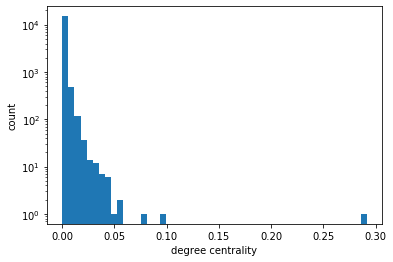

DescribeResult(nobs=15759, minmax=(6.345982992765579e-05, 0.29147099885772304), mean=0.0013891094620333958, variance=1.4107405989212647e-05, skewness=33.64210404015354, kurtosis=2315.5960434945187)

In [88]:
# Plot distribution of degree centralities in the network
plt.figure()
plt.hist(centrality_dic.values(), bins=50)
plt.yscale('log')
plt.xlabel('degree centrality')
plt.ylabel('count')
plt.show()
ss.describe(list(centrality_dic.values()))